In [ ]:
# analysis paper
# import libraries

import seaborn as sns
import numpy as np
import scipy.stats as _stats
from functools import reduce
from pipeline.analysis import *
from pipeline.utils import *
from pipeline import *
import logging
import networkx as nx
import glob
from scipy.stats import sem as sem
from matplotlib import colormaps
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from os.path import join
import sys
from matplotlib.ticker import MaxNLocator

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=RuntimeWarning)
# warnings.simplefilter(action='ignore', category=SettingWithCopyWarning)

logging.getLogger().setLevel(logging.INFO)

from cinnabar import wrangle as _wrangle


In [ ]:
# additional functions

def check_normal_dist(values):
    # check normally dist
    if len(values) < 50:
        stat, p = _stats.shapiro(values)
    else:
        stat, p = _stats.kstest(values)
    if p < 0.05:
        return True
    else:
        return False


def flatten_comprehension(matrix):
    return [item for row in matrix for item in row]

In [ ]:
# define the analysis method to use - uncomment as required
ana_dicts = {
    "plain": {
        "estimator": "MBAR",
        "method": "alchemlyb",
        "check overlap": True,
        "try pickle": True,
        "save pickle": True,
        "auto equilibration": False,
        "statistical inefficiency": False,
        "truncate lower": 0,
        "truncate upper": 100,
        "name": None,
    },
    # "subsampling": {
    #     "estimator": "MBAR",
    #     "method": "alchemlyb",
    #     "check overlap": True,
    #     "try pickle": True,
    #     "save pickle": True,
    #     "auto equilibration": False,
    #     "statistical inefficiency": True,
    #     "truncate lower": 0,
    #     "truncate upper": 100,
    #     "name": None,
    # },
    # "1ns": {
    #     "estimator": "MBAR",
    #     "method": "alchemlyb",
    #     "check overlap": True,
    #     "try pickle": True,
    #     "save pickle": True,
    #     "auto equilibration": False,
    #     "statistical inefficiency": False,
    #     "truncate lower": 0,
    #     "truncate upper": 25,
    #     "name": None,
    # },
    # "2ns": {
    #     "estimator": "MBAR",
    #     "method": "alchemlyb",
    #     "check overlap": True,
    #     "try pickle": True,
    #     "save pickle": True,
    #     "auto equilibration": False,
    #     "statistical inefficiency": False,
    #     "truncate lower": 0,
    #     "truncate upper": 50,
    #     "name": None,
    # },
    # "3ns": {
    #     "estimator": "MBAR",
    #     "method": "alchemlyb",
    #     "check overlap": True,
    #     "try pickle": True,
    #     "save pickle": True,
    #     "auto equilibration": False,
    #     "statistical inefficiency": False,
    #     "truncate lower": 0,
    #     "truncate upper": 75,
    #     "name": None,
    # },
    # "autoeq": {
    #     "estimator": "MBAR",
    #     "method": "alchemlyb",
    #     "check overlap": True,
    #     "try pickle": True,
    #     "save pickle": True,
    #     "auto equilibration": True,
    #     "statistical inefficiency": True,
    #     "truncate lower": 0,
    #     "truncate upper": 100,
    #     "name": None,
    # },
}

In [ ]:
# set the colours and the names for plotting.

prot_dict_name = {
    "tyk2": "TYK2",
    "mcl1": "MCL1",
    "p38": "P38α",
    "syk": "SYK",
    "hif2a": "HIF2A",
    "cmet": "CMET",
}
eng_dict_name = {"AMBER": "AMBER22", "SOMD": "SOMD1", "GROMACS": "GROMACS23", "hahn": "Hahn et al.", "openfe": "OpenFE", "fepplus": "Ross et al."}

set_cols = pipeline.analysis.set_colours(other_results_names=["hahn","openfe","fepplus"], colour_dict={"openfe":"dimgrey",
                                                                                                        "hahn":'darkgrey', 
                                                                                                        "fepplus":"lightgrey"})
col_dict = {}
for eng in eng_dict_name:
    col_dict[eng_dict_name[eng]] = set_cols[eng]

In [ ]:
# set file paths so the location of the repository is used.
main_dir = "/".join(os.getcwd().split("/")[:-1])

In [ ]:
# setup all the different networks, proteins, and analysis methods for later use.

network_dict = {}

for network in ["lomap", "rbfenn", "flare", "combined", "lomap-a-optimal", "lomap-d-optimal", "rbfenn-a-optimal", "rbfenn-d-optimal"]:
    # all the options
    ana_obj_dict = {}

    for protein in ["tyk2", "mcl1", "p38", "syk", "hif2a", "cmet"]:  #
        print(protein, network)
        ana_obj_dict[protein] = {}

        for ana_dict in ana_dicts:
            ana_prot = analysis_protocol(ana_dicts[ana_dict])

            # choose location for the files
            if protein == "syk" or protein == "cmet" or protein == "hif2a":
                # the lomap network
                if network == "lomap":
                    net_file = f"{main_dir}/inputs/networks/{protein}/network_lomap.dat"
                elif network == "combined":
                    net_file = f"{main_dir}/inputs/networks/{protein}/network_lomap.dat"
                else:
                    ana_obj_dict[protein][ana_dict] = None
                    continue
            elif protein == "p38":
                if network == "lomap-a-optimal" or network == "lomap-d-optimal" or network == "rbfenn-a-optimal" or network == "rbfenn-d-optimal":
                    ana_obj_dict[protein][ana_dict] = None
                    continue
                else:
                    net_file = f"{main_dir}/inputs/networks/{protein}/network_{network}.dat"

            else:
                net_file = f"{main_dir}/inputs/networks/{protein}/network_{network}.dat"

            exp_file = f"{main_dir}/inputs/experimental/{protein}.yml"
            output_folder = f"{main_dir}/results/{protein}"

            pipeline_prot = pipeline_protocol(auto_validate=True)

            all_analysis_object = analysis_network(
                output_folder,
                exp_file=exp_file,
                net_file=net_file,
                analysis_prot=ana_prot,
            )

            # compute
            try:
                all_analysis_object.compute_results()
            except Exception as e:
                print(e)
                print("failed analysis")

            # add ligands folder
            all_analysis_object.add_ligands_folder(
                f"{main_dir}/inputs/protein_systems/{protein}/ligands"
            )

            ana_obj_dict[protein][ana_dict] = all_analysis_object

    # print(ana_obj_dict)

    network_dict[network] = ana_obj_dict

In [36]:
ana_obj_dict = network_dict["lomap"]

# initial 
ana_obj = ana_obj_dict["tyk2"]["plain"]


In [ ]:
# check maximum possible accuracy
r2_dict = {}
r2_error_dict = {}
for prot in prot_dict_name.keys():
    r2_dict[prot] = {}
    r2_error_dict[prot] = {}
    ana_obj = ana_obj_dict[prot]["plain"]
    print(prot, len(ana_obj.ligands))
    print(
        "max",
        max(ana_obj.exper_val_dict.values())[0],
        "min",
        min(ana_obj.exper_val_dict.values())[0],
        "range",
        max(ana_obj.exper_val_dict.values())[0]
        - min(ana_obj.exper_val_dict.values())[0],
    )
    avg = np.mean([val[1] for val in ana_obj.exper_val_dict.values()])
    std = np.std([val[0] for val in ana_obj.exper_val_dict.values()])
    print("mean of error", avg, "std of val", std)
    # experimental uncertainty is std of measurement error
    # max is measurement error / std dev of the affinity , squared
    # tyk2 mcl1 Ki 0.44
    # others IC50 0.75
    r2max = 1 - (avg / std) ** 2
    print(r2max)
    r2_dict[prot]["maximum"] = r2max
    r2_error_dict[prot]["maximum"] = (0, 0)

In [ ]:
# check the number of shared perturbations between different networks

for net1, net2 in it.combinations(["lomap", "rbfenn", "flare"], 2): #  , "lomap-a-optimal", "lomap-d-optimal", "rbfenn-a-optimal", "rbfenn-d-optimal"

    share_all = 0
    perts_all = []

    for prot in ["tyk2","mcl1","p38"]: # , "mcl1", "p38"

        share = 0
        diff = 0

        shared = 0
        perts = deepcopy(network_dict[net1][prot]["plain"].perturbations)
        for pert in network_dict[net2][prot]["plain"].perturbations:
            if pert not in network_dict[net1][prot]["plain"].perturbations:
                perts.append(pert)
            if pert in network_dict[net1][prot]["plain"].perturbations:
                share += 1
                share_all += 1
        perts_all.append(perts)

        print(f"{net1} {net2} shared perts: { share / len(perts)}")

    print(f"perts all: { share_all / len(flatten_comprehension(perts_all)) }")


In [17]:
# identify any outliers or failed perturbations

failed_perts_dict_percen = {}
failed_perts_dict = {}

ana_obj_dict = network_dict["combined"]

for prot in ana_obj_dict.keys():
    failed_perts_dict_percen[prot_dict_name[prot]] = {}
    failed_perts_dict[prot_dict_name[prot]] = {}
    ana_obj = ana_obj_dict[prot]["plain"]
    print(prot)
    for eng in ana_obj.engines:  # ana_obj.engines
        failed_perts_dict_percen[prot_dict_name[prot]][eng_dict_name[eng]] = (
            100 - ana_obj.successful_perturbations(eng)[1]
        )
        failed_perts_dict[prot_dict_name[prot]][eng_dict_name[eng]] = ana_obj.failed_perturbations(eng)
        print(
            f"failed percentage for {eng}: {100 - ana_obj.successful_perturbations(eng)[1]} ({len(ana_obj.perturbations) - len(ana_obj.successful_perturbations(eng)[2])} / {len(ana_obj.perturbations)})"
        )
        print(f"{eng} failed perturbations: {ana_obj.failed_perturbations(engine=eng)}")
        print(f"{eng} disconnected ligands: {ana_obj.disconnected_ligands(engine=eng)}")
        print(f"outliers {eng}: {ana_obj.get_outliers(threshold=10, name=eng)}")

INFO:root:61 out of 62 have results, which is 98.38709677419355 %.
INFO:root:61 out of 62 have results, which is 98.38709677419355 %.
INFO:root:61 out of 62 have results, which is 98.38709677419355 %.
INFO:root:61 out of 62 have results, which is 98.38709677419355 %.
INFO:root:61 out of 62 have results, which is 98.38709677419355 %.
INFO:root:61 out of 62 have results, which is 98.38709677419355 %.


tyk2
failed percentage for AMBER: 1.6129032258064484 (1 / 62)
AMBER failed perturbations: ['lig_jmc27~lig_jmc28']


INFO:root:60 out of 62 have results, which is 96.7741935483871 %.
INFO:root:60 out of 62 have results, which is 96.7741935483871 %.
INFO:root:60 out of 62 have results, which is 96.7741935483871 %.
INFO:root:60 out of 62 have results, which is 96.7741935483871 %.
INFO:root:60 out of 62 have results, which is 96.7741935483871 %.
INFO:root:60 out of 62 have results, which is 96.7741935483871 %.
INFO:root:62 out of 62 have results, which is 100.0 %.
INFO:root:62 out of 62 have results, which is 100.0 %.
INFO:root:62 out of 62 have results, which is 100.0 %.
INFO:root:62 out of 62 have results, which is 100.0 %.
INFO:root:62 out of 62 have results, which is 100.0 %.
INFO:root:62 out of 62 have results, which is 100.0 %.


AMBER disconnected ligands: []
outliers AMBER: []
failed percentage for SOMD: 3.225806451612897 (2 / 62)
SOMD failed perturbations: ['lig_ejm50~lig_ejm54', 'lig_ejm50~lig_ejm55']
SOMD disconnected ligands: []
outliers SOMD: []
failed percentage for GROMACS: 0.0 (0 / 62)
GROMACS failed perturbations: []


INFO:root:53 out of 53 have results, which is 100.0 %.
INFO:root:53 out of 53 have results, which is 100.0 %.
INFO:root:53 out of 53 have results, which is 100.0 %.
INFO:root:53 out of 53 have results, which is 100.0 %.
INFO:root:53 out of 53 have results, which is 100.0 %.
INFO:root:53 out of 53 have results, which is 100.0 %.
INFO:root:53 out of 53 have results, which is 100.0 %.
INFO:root:53 out of 53 have results, which is 100.0 %.
INFO:root:53 out of 53 have results, which is 100.0 %.
INFO:root:53 out of 53 have results, which is 100.0 %.
INFO:root:53 out of 53 have results, which is 100.0 %.
INFO:root:53 out of 53 have results, which is 100.0 %.


GROMACS disconnected ligands: []
outliers GROMACS: []
mcl1
failed percentage for AMBER: 0.0 (4 / 57)
AMBER failed perturbations: []
AMBER disconnected ligands: []
outliers AMBER: []
failed percentage for SOMD: 0.0 (4 / 57)
SOMD failed perturbations: []


INFO:root:53 out of 53 have results, which is 100.0 %.
INFO:root:53 out of 53 have results, which is 100.0 %.
INFO:root:53 out of 53 have results, which is 100.0 %.
INFO:root:53 out of 53 have results, which is 100.0 %.
INFO:root:53 out of 53 have results, which is 100.0 %.
INFO:root:53 out of 53 have results, which is 100.0 %.
INFO:root:128 out of 132 have results, which is 96.96969696969697 %.
INFO:root:128 out of 132 have results, which is 96.96969696969697 %.
INFO:root:128 out of 132 have results, which is 96.96969696969697 %.
INFO:root:128 out of 132 have results, which is 96.96969696969697 %.
INFO:root:128 out of 132 have results, which is 96.96969696969697 %.
INFO:root:128 out of 132 have results, which is 96.96969696969697 %.


SOMD disconnected ligands: []
outliers SOMD: []
failed percentage for GROMACS: 0.0 (4 / 57)
GROMACS failed perturbations: []
GROMACS disconnected ligands: []
outliers GROMACS: []
p38
failed percentage for AMBER: 3.030303030303031 (4 / 132)
AMBER failed perturbations: ['lig_2aa~lig_2z', 'lig_2r~lig_2s', 'lig_2n~lig_2s', 'lig_2aa~Intermediate_2']


INFO:root:131 out of 132 have results, which is 99.24242424242425 %.
INFO:root:131 out of 132 have results, which is 99.24242424242425 %.
INFO:root:131 out of 132 have results, which is 99.24242424242425 %.
INFO:root:131 out of 132 have results, which is 99.24242424242425 %.
INFO:root:131 out of 132 have results, which is 99.24242424242425 %.
INFO:root:131 out of 132 have results, which is 99.24242424242425 %.


AMBER disconnected ligands: []
outliers AMBER: []
failed percentage for SOMD: 0.7575757575757507 (1 / 132)
SOMD failed perturbations: ['lig_2u~lig_2x']


INFO:root:132 out of 132 have results, which is 100.0 %.
INFO:root:132 out of 132 have results, which is 100.0 %.
INFO:root:132 out of 132 have results, which is 100.0 %.
INFO:root:132 out of 132 have results, which is 100.0 %.
INFO:root:132 out of 132 have results, which is 100.0 %.
INFO:root:132 out of 132 have results, which is 100.0 %.


SOMD disconnected ligands: []
outliers SOMD: []
failed percentage for GROMACS: 0.0 (0 / 132)
GROMACS failed perturbations: []


INFO:root:49 out of 49 have results, which is 100.0 %.
INFO:root:49 out of 49 have results, which is 100.0 %.
INFO:root:49 out of 49 have results, which is 100.0 %.
INFO:root:49 out of 49 have results, which is 100.0 %.
INFO:root:49 out of 49 have results, which is 100.0 %.
INFO:root:49 out of 49 have results, which is 100.0 %.


GROMACS disconnected ligands: []
outliers GROMACS: []
syk
failed percentage for AMBER: 0.0 (0 / 49)
AMBER failed perturbations: []


INFO:root:49 out of 49 have results, which is 100.0 %.
INFO:root:49 out of 49 have results, which is 100.0 %.
INFO:root:49 out of 49 have results, which is 100.0 %.
INFO:root:49 out of 49 have results, which is 100.0 %.
INFO:root:49 out of 49 have results, which is 100.0 %.
INFO:root:49 out of 49 have results, which is 100.0 %.


AMBER disconnected ligands: []
outliers AMBER: []
failed percentage for SOMD: 0.0 (0 / 49)
SOMD failed perturbations: []


INFO:root:49 out of 49 have results, which is 100.0 %.
INFO:root:49 out of 49 have results, which is 100.0 %.
INFO:root:49 out of 49 have results, which is 100.0 %.
INFO:root:49 out of 49 have results, which is 100.0 %.
INFO:root:49 out of 49 have results, which is 100.0 %.
INFO:root:49 out of 49 have results, which is 100.0 %.


SOMD disconnected ligands: []
outliers SOMD: []
failed percentage for GROMACS: 0.0 (0 / 49)
GROMACS failed perturbations: []


INFO:root:40 out of 42 have results, which is 95.23809523809523 %.
INFO:root:40 out of 42 have results, which is 95.23809523809523 %.
INFO:root:40 out of 42 have results, which is 95.23809523809523 %.
INFO:root:40 out of 42 have results, which is 95.23809523809523 %.
INFO:root:40 out of 42 have results, which is 95.23809523809523 %.
INFO:root:40 out of 42 have results, which is 95.23809523809523 %.


GROMACS disconnected ligands: []
outliers GROMACS: []
hif2a
failed percentage for AMBER: 4.761904761904773 (2 / 42)
AMBER failed perturbations: ['lig_155~lig_23', 'lig_23~lig_251']


INFO:root:42 out of 42 have results, which is 100.0 %.
INFO:root:42 out of 42 have results, which is 100.0 %.
INFO:root:42 out of 42 have results, which is 100.0 %.
INFO:root:42 out of 42 have results, which is 100.0 %.
INFO:root:42 out of 42 have results, which is 100.0 %.
INFO:root:42 out of 42 have results, which is 100.0 %.


AMBER disconnected ligands: ['lig_23']
outliers AMBER: []
failed percentage for SOMD: 0.0 (0 / 42)
SOMD failed perturbations: []


INFO:root:42 out of 42 have results, which is 100.0 %.
INFO:root:42 out of 42 have results, which is 100.0 %.
INFO:root:42 out of 42 have results, which is 100.0 %.
INFO:root:42 out of 42 have results, which is 100.0 %.
INFO:root:42 out of 42 have results, which is 100.0 %.
INFO:root:42 out of 42 have results, which is 100.0 %.


SOMD disconnected ligands: []
outliers SOMD: []
failed percentage for GROMACS: 0.0 (0 / 42)
GROMACS failed perturbations: []


INFO:root:16 out of 16 have results, which is 100.0 %.
INFO:root:16 out of 16 have results, which is 100.0 %.
INFO:root:16 out of 16 have results, which is 100.0 %.
INFO:root:16 out of 16 have results, which is 100.0 %.
INFO:root:16 out of 16 have results, which is 100.0 %.
INFO:root:16 out of 16 have results, which is 100.0 %.
INFO:root:16 out of 16 have results, which is 100.0 %.
INFO:root:16 out of 16 have results, which is 100.0 %.
INFO:root:16 out of 16 have results, which is 100.0 %.
INFO:root:16 out of 16 have results, which is 100.0 %.
INFO:root:16 out of 16 have results, which is 100.0 %.
INFO:root:16 out of 16 have results, which is 100.0 %.


GROMACS disconnected ligands: []
outliers GROMACS: []
cmet
failed percentage for AMBER: 0.0 (0 / 16)
AMBER failed perturbations: []
AMBER disconnected ligands: []
outliers AMBER: []
failed percentage for SOMD: 0.0 (0 / 16)
SOMD failed perturbations: []


INFO:root:16 out of 16 have results, which is 100.0 %.
INFO:root:16 out of 16 have results, which is 100.0 %.
INFO:root:16 out of 16 have results, which is 100.0 %.
INFO:root:16 out of 16 have results, which is 100.0 %.
INFO:root:16 out of 16 have results, which is 100.0 %.
INFO:root:16 out of 16 have results, which is 100.0 %.


SOMD disconnected ligands: []
outliers SOMD: []
failed percentage for GROMACS: 0.0 (0 / 16)
GROMACS failed perturbations: []
GROMACS disconnected ligands: []
outliers GROMACS: []


In [18]:
# list of the 2 fs and reverse runs
failed_dict = failed_perts_dict
twofs_run_dict = {
    "TYK2": {
        "AMBER22": ["lig_ejm48~lig_ejm53", "lig_ejm31~lig_ejm54", "lig_ejm31~lig_ejm43"],
        "SOMD1": [],
        "GROMACS23": [],
    },
    "MCL1": {
        "AMBER22": ['lig_27~lig_39', 'lig_32~lig_34', 'lig_65~lig_67', 'lig_53~lig_58', 'lig_53~lig_63', 'lig_37~lig_65', 'lig_37~lig_67', 'lig_39~lig_67',
                  'lig_61~lig_63', 'lig_27~lig_65', 'lig_27~lig_60', 'lig_27~lig_63', 'lig_34~lig_53', 'lig_27~lig_37', 'lig_50~lig_56'],
        "SOMD1": [],
        "GROMACS23": [],
    },
    "P38α": {
        "AMBER22": ["lig_2y~lig_2w", "lig_2ee~lig_2a", "lig_2ff~lig_2g", "lig_2bb~lig_2z", "lig_2ee~lig_2l", "lig_2gg~lig_2j", "lig_2ee~lig_2j",
                  "lig_2ee~lig_2w", "lig_2p~lig_2t", "lig_2ii~lig_2v", "lig_2m~lig_2x", "lig_2a~lig_2gg", "lig_2ii~Intermediate_6"],
        "SOMD1": ["lig_2b~lig_2h", "lig_2dd~lig_2hh"],
        "GROMACS23": ['lig_2bb~lig_2w', 'lig_2j~lig_2k', 'lig_2n~lig_2a', 'lig_2o~lig_2a', 'lig_2p~lig_2a', 'lig_2t~lig_2a', 'lig_2y~lig_2w', 'lig_2dd~lig_2w',
                    'lig_2b~Intermediate_2', 'lig_2d~Intermediate', 'lig_2bb~lig_2v', 'lig_2aa~lig_2v', 'lig_2b~lig_2w', 'lig_2b~lig_2z', 'lig_2ii~lig_2v',
                    'lig_2t~lig_2x', 'lig_2l~lig_2x', 'lig_2gg~lig_2k', 'lig_2a~lig_2k'],
    },
    "SYK": {
        "AMBER22": ["lig_CHEMBL3265005~lig_CHEMBL3265026", "lig_CHEMBL3265016~lig_CHEMBL3265018", "lig_CHEMBL3265018~lig_CHEMBL3265020",
                  "lig_CHEMBL3265025~lig_CHEMBL3265026", "lig_CHEMBL3265017~lig_CHEMBL3265021"],
        "SOMD1": [],
        "GROMACS23": ["lig_CHEMBL3259820~lig_CHEMBL3264999", "lig_CHEMBL3264996~lig_CHEMBL3264999", "lig_CHEMBL3265006~lig_CHEMBL3265009",
                    "lig_CHEMBL3259820~lig_CHEMBL3265005", "lig_CHEMBL3265005~lig_CHEMBL3265026"],
    },
    "HIF2A": {
        "AMBER22": [],
        "SOMD1": [],
        "GROMACS23": ["lig_235~lig_266","lig_251~lig_256"],
    },
    "CMET": {
        "AMBER22": ["lig_CHEMBL3402753_200~lig_CHEMBL3402761_1", "lig_CHEMBL3402744_300~lig_CHEMBL3402745_200", "lig_CHEMBL3402747_3400~lig_CHEMBL3402751_2100",
                  "lig_CHEMBL3402754_40~lig_CHEMBL3402755_4200", "lig_CHEMBL3402753_200~lig_CHEMBL3402754_40"],
        "SOMD1": [],
        "GROMACS23": ["lig_CHEMBL3402744_300~lig_CHEMBL3402748_5300", "lig_CHEMBL3402744_300~lig_CHEMBL3402753_200"],
    },
}
reverse_run_dict = {
    "TYK2": {
        "AMBER22": [],
        "SOMD1": [],
        "GROMACS23": [],
    },
    "MCL1": {
        "AMBER22": ['lig_65~lig_67', 'lig_37~lig_67', 'lig_39~lig_67', 'lig_61~lig_63'],
        "SOMD1": [],
        "GROMACS23": [],
    },
    "P38α": {
        "AMBER22": [],
        "SOMD1": [],
        "GROMACS23": [],
    },
    "SYK": {
        "AMBER22": [],
        "SOMD1": [],
        "GROMACS23": [],
    },
    "HIF2A": {
        "AMBER22": [],
        "SOMD1": [],
        "GROMACS23": [],
    },
    "CMET": {
        "AMBER22": [],
        "SOMD1": [],
        "GROMACS23": [],
    },
}

failed_actual_dict = {
    "TYK2": {
        "AMBER22": len(failed_dict["TYK2"]["AMBER22"]),
        "SOMD1": len(failed_dict["TYK2"]["SOMD1"]),
        "GROMACS23": len(failed_dict["TYK2"]["GROMACS23"]),
    },
    "MCL1": {
        "AMBER22": len(failed_dict["MCL1"]["AMBER22"]),
        "SOMD1": len(failed_dict["MCL1"]["SOMD1"]),
        "GROMACS23": len(failed_dict["MCL1"]["GROMACS23"]),
    },
    "P38α": {
        "AMBER22": len(failed_dict["P38α"]["AMBER22"]),
        "SOMD1": len(failed_dict["P38α"]["SOMD1"]),
        "GROMACS23": len(failed_dict["P38α"]["GROMACS23"]),
    },
    "SYK": {
        "AMBER22": len(failed_dict["SYK"]["AMBER22"]),
        "SOMD1": len(failed_dict["SYK"]["SOMD1"]),
        "GROMACS23": len(failed_dict["SYK"]["GROMACS23"]),
    },
    "HIF2A": {
        "AMBER22": len(failed_dict["HIF2A"]["AMBER22"]),
        "SOMD1": len(failed_dict["HIF2A"]["SOMD1"]),
        "GROMACS23": len(failed_dict["HIF2A"]["GROMACS23"]),
    },
    "CMET": {
        "AMBER22": len(failed_dict["CMET"]["AMBER22"]),
        "SOMD1": len(failed_dict["CMET"]["SOMD1"]),
        "GROMACS23": len(failed_dict["CMET"]["GROMACS23"]),
    },
}
twofs_dict = {
    "TYK2": {
        "AMBER22": len(twofs_run_dict["TYK2"]["AMBER22"]),
        "SOMD1": len(twofs_run_dict["TYK2"]["SOMD1"]),
        "GROMACS23": len(twofs_run_dict["TYK2"]["GROMACS23"]),
    },
    "MCL1": {
        "AMBER22": len(twofs_run_dict["MCL1"]["AMBER22"]),
        "SOMD1": len(twofs_run_dict["MCL1"]["SOMD1"]),
        "GROMACS23": len(twofs_run_dict["MCL1"]["GROMACS23"]),
    },
    "P38α": {
        "AMBER22": len(twofs_run_dict["P38α"]["AMBER22"]),
        "SOMD1": len(twofs_run_dict["P38α"]["SOMD1"]),
        "GROMACS23": len(twofs_run_dict["P38α"]["GROMACS23"]),
    },
    "SYK": {
        "AMBER22": len(twofs_run_dict["SYK"]["AMBER22"]),
        "SOMD1": len(twofs_run_dict["SYK"]["SOMD1"]),
        "GROMACS23": len(twofs_run_dict["SYK"]["GROMACS23"]),
    },
    "HIF2A": {
        "AMBER22": len(twofs_run_dict["HIF2A"]["AMBER22"]),
        "SOMD1": len(twofs_run_dict["HIF2A"]["SOMD1"]),
        "GROMACS23": len(twofs_run_dict["HIF2A"]["GROMACS23"]),
    },
    "CMET": {
        "AMBER22": len(twofs_run_dict["CMET"]["AMBER22"]),
        "SOMD1": len(twofs_run_dict["CMET"]["SOMD1"]),
        "GROMACS23": len(twofs_run_dict["CMET"]["GROMACS23"]),
    },
}
reverse_dict = {
    "TYK2": {
        "AMBER22": len(reverse_run_dict["TYK2"]["AMBER22"]),
        "SOMD1": len(reverse_run_dict["TYK2"]["SOMD1"]),
        "GROMACS23": len(reverse_run_dict["TYK2"]["GROMACS23"]),
    },
    "MCL1": {
        "AMBER22": len(reverse_run_dict["MCL1"]["AMBER22"]),
        "SOMD1": len(reverse_run_dict["MCL1"]["SOMD1"]),
        "GROMACS23": len(reverse_run_dict["MCL1"]["GROMACS23"]),
    },
    "P38α": {
        "AMBER22": len(reverse_run_dict["P38α"]["AMBER22"]),
        "SOMD1": len(reverse_run_dict["P38α"]["SOMD1"]),
        "GROMACS23": len(reverse_run_dict["P38α"]["GROMACS23"]),
    },
    "SYK": {
        "AMBER22": len(reverse_run_dict["SYK"]["AMBER22"]),
        "SOMD1": len(reverse_run_dict["SYK"]["SOMD1"]),
        "GROMACS23": len(reverse_run_dict["SYK"]["GROMACS23"]),
    },
    "HIF2A": {
        "AMBER22": len(reverse_run_dict["HIF2A"]["AMBER22"]),
        "SOMD1": len(reverse_run_dict["HIF2A"]["SOMD1"]),
        "GROMACS23": len(reverse_run_dict["HIF2A"]["GROMACS23"]),
    },
    "CMET": {
        "AMBER22": len(reverse_run_dict["CMET"]["AMBER22"]),
        "SOMD1": len(reverse_run_dict["CMET"]["SOMD1"]),
        "GROMACS23": len(reverse_run_dict["CMET"]["GROMACS23"]),
    },
}

df_failed = pd.DataFrame(failed_actual_dict).T
df_twofs = pd.DataFrame(twofs_dict).T
df_reverse = pd.DataFrame(reverse_dict).T

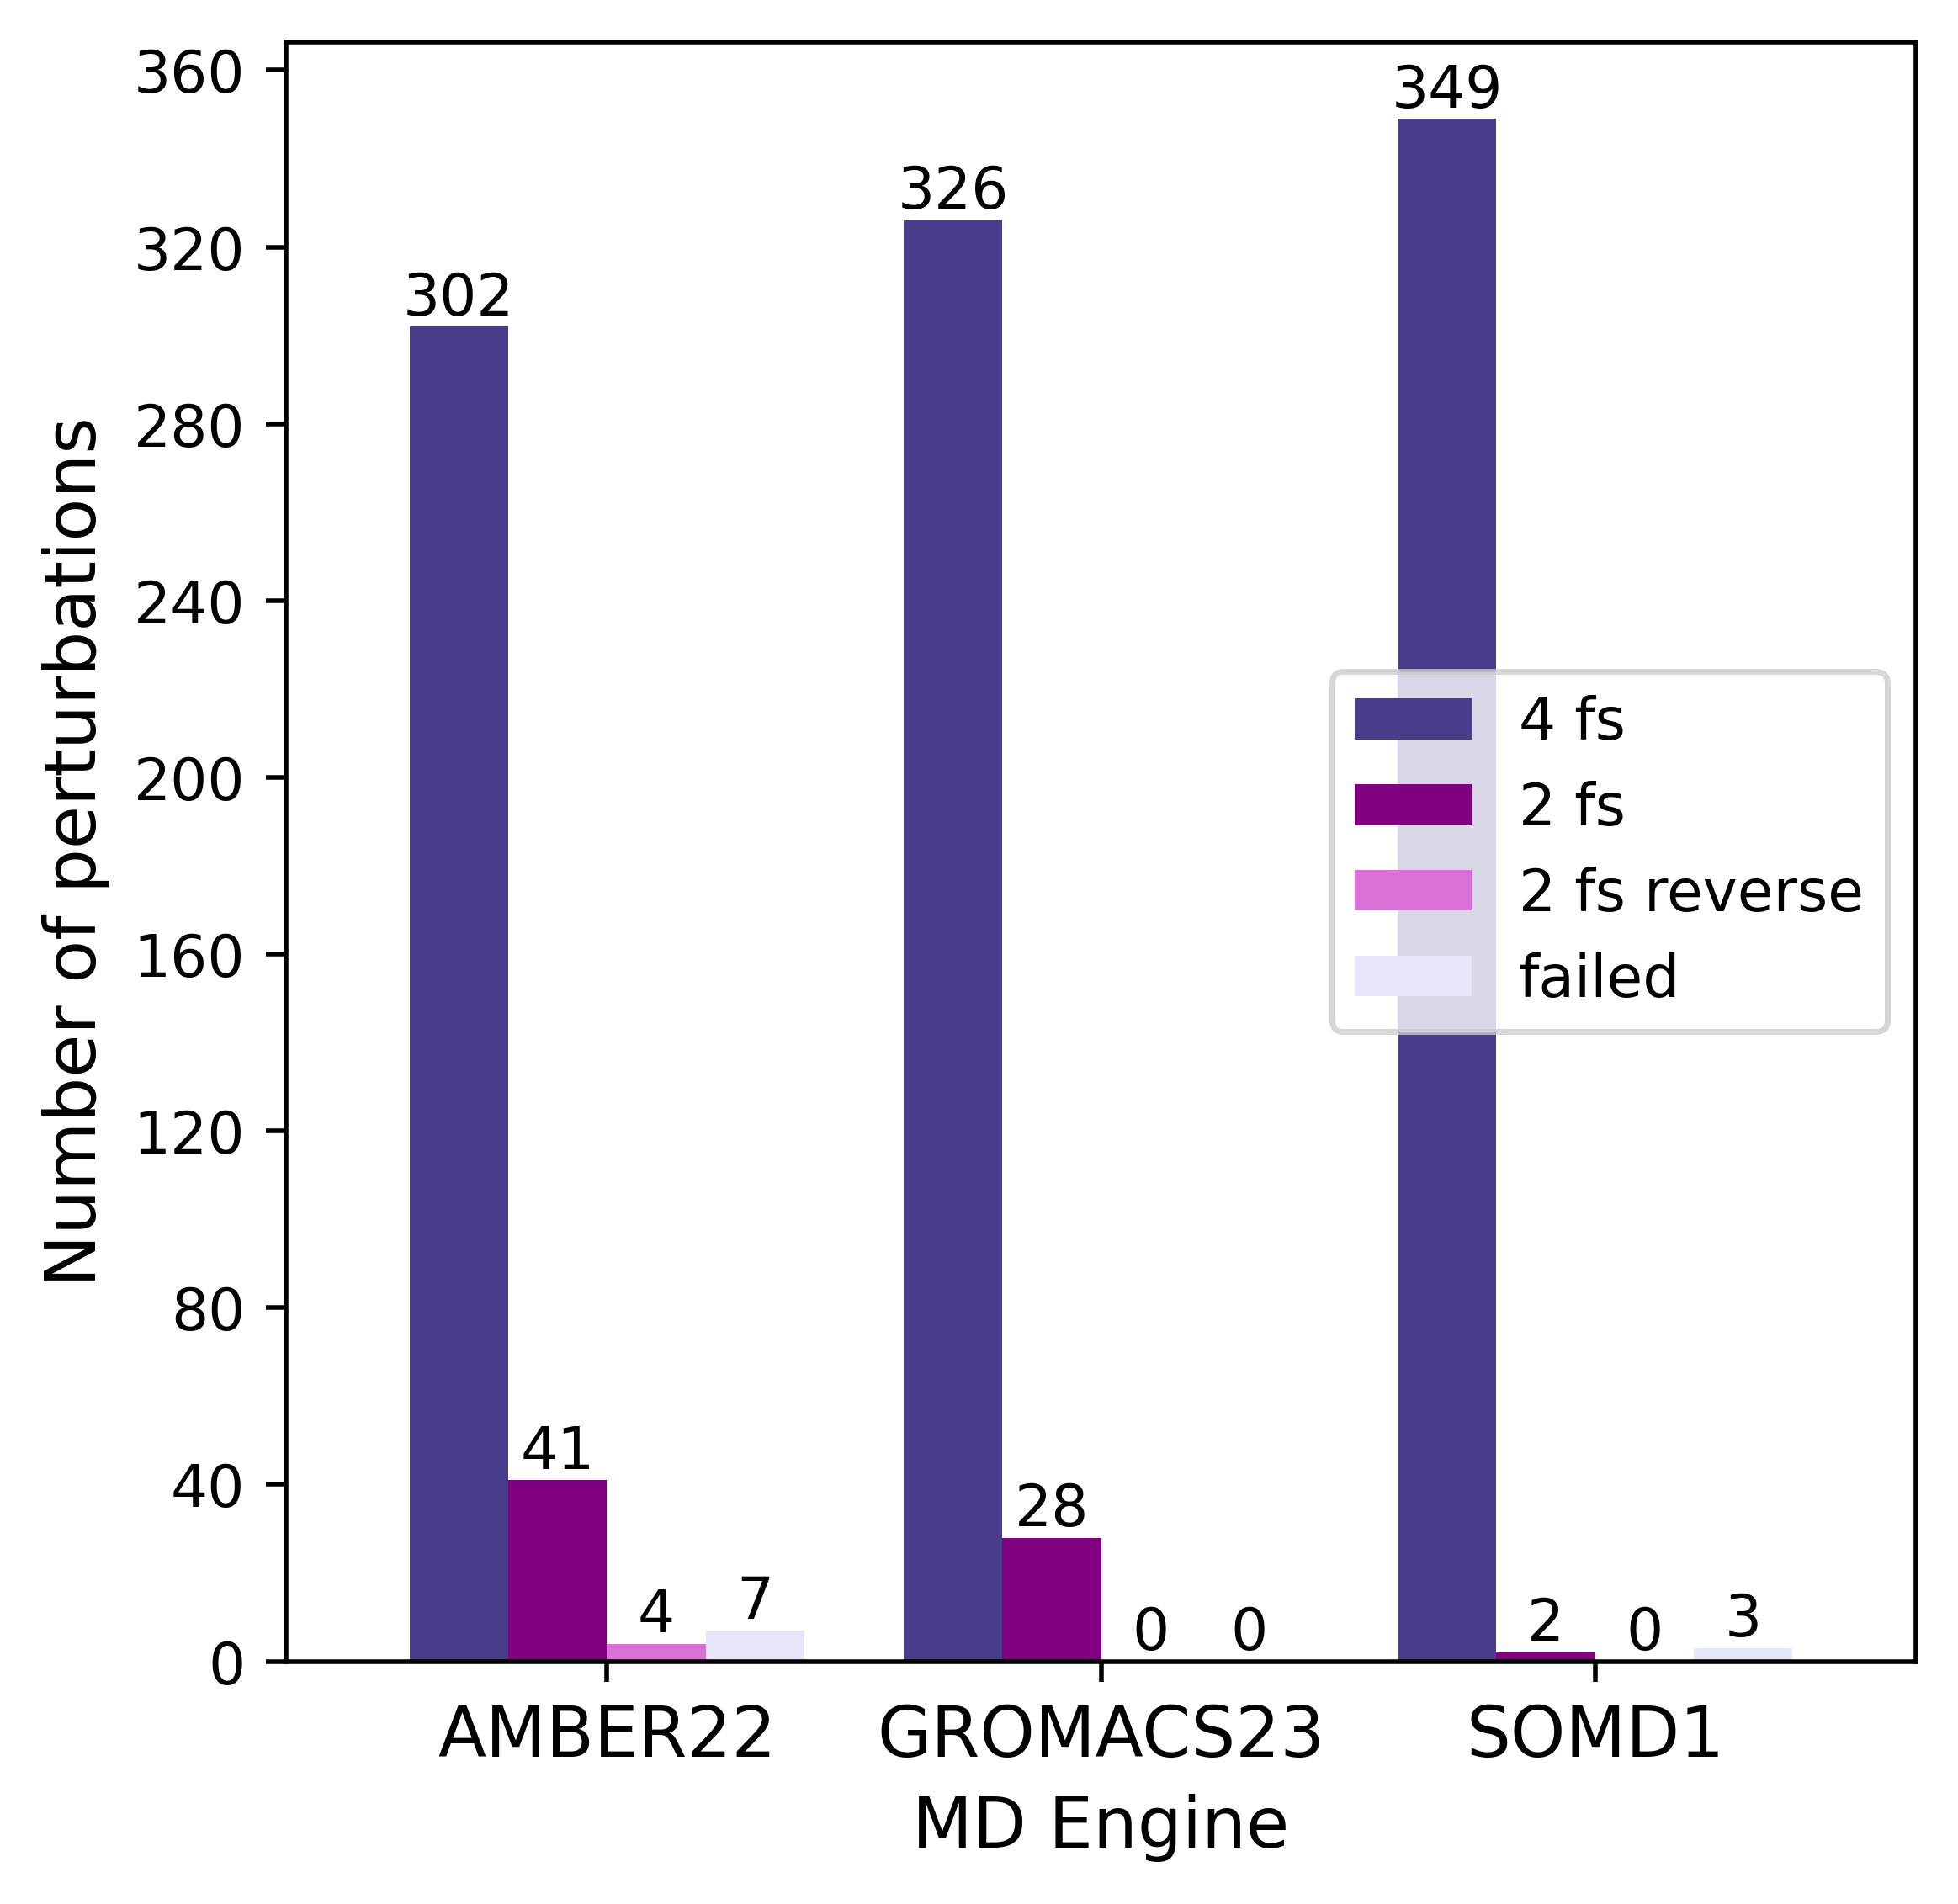

In [19]:
adaptive_protocol_dict = {
    "AMBER22": {
        "4 fs": 354
        - (
            np.sum(df_reverse["AMBER22"])
            + np.sum(df_twofs["AMBER22"])
            + np.sum(df_failed["AMBER22"])
        ),
        "2 fs": np.sum(df_twofs["AMBER22"]),
        "2 fs reverse": np.sum(df_reverse["AMBER22"]),
        "failed": np.sum(df_failed["AMBER22"]),
    },
    "GROMACS23": {
        "4 fs": 354
        - (
            np.sum(df_reverse["GROMACS23"])
            + np.sum(df_twofs["GROMACS23"])
            + np.sum(df_failed["GROMACS23"])
        ),
        "2 fs": np.sum(df_twofs["GROMACS23"]),
        "2 fs reverse": np.sum(df_reverse["GROMACS23"]),
        "failed": np.sum(df_failed["GROMACS23"]),
    },
    "SOMD1": {
        "4 fs": 354
        - (
            np.sum(df_reverse["SOMD1"])
            + np.sum(df_twofs["SOMD1"])
            + np.sum(df_failed["SOMD1"])
        ),
        "2 fs": np.sum(df_twofs["SOMD1"]),
        "2 fs reverse": np.sum(df_reverse["SOMD1"]),
        "failed": np.sum(df_failed["SOMD1"]),
    },
}
# for key in adaptive_protocol_dict:
#     print(key)
#     assert np.sum(adaptive_protocol_dict[key].values) == 354
# total no of perturbations is 354
df = pd.DataFrame(adaptive_protocol_dict).T.rename(eng_dict_name)

fig, ax = plt.subplots(figsize=(5, 5), dpi=500)
df.plot(
    color=["darkslateblue", "purple", "orchid", "lavender"],
    kind="bar",
    xlabel="MD engine",
    ylabel="Number of perturbations",
    ax=ax,
    width=0.8,
)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
for p in ax.patches:
    ax.annotate(
        str(p.get_height()), (p.get_x() + p.get_width() / 2., p.get_height()), 
        ha='center', va='bottom', fontsize=10, color='black'
    )

ax.legend(loc="center right", fontsize=10)
plt.xlabel("MD Engine", fontsize=12)
plt.ylabel("Number of perturbations", fontsize=12)
plt.tick_params(axis="x", labelsize=12, rotation=0)
plt.tick_params(axis="y", labelsize=10, rotation=0)

In [23]:
# calcualte the differences in SEM
# SEM differences

sem_dict = {}
sem_dict_name = {}

for name in ana_dicts:
    sem_list_name = []
    sem_dict[name] = {}

    for prot in ana_obj_dict.keys():
        sem_dict[name][prot] = {}

        ana_obj = ana_obj_dict[prot][name]  # subsampling

        for eng in ana_obj.engines:
            sem_dict[name][prot][eng] = {}

            sem_list = []
            sems = [val[1] for val in ana_obj.calc_pert_dict[eng].values()]
            sem_list.append(sems)
            sem_list_name.append(sems)

            sem_list = reduce(lambda xs, ys: xs + ys, sem_list)
            sem_list = [x for x in sem_list if str(x) != "nan"]

            # if not check_normal_dist(sem_list):
            #     print(f"{prot} {name} not normally dist")

            mean = np.mean(sem_list)
            lower_ci, upper_ci = _stats.norm.interval(
                confidence=0.95, loc=np.mean(sem_list), scale=_stats.sem(sem_list)
            )

            print(prot, name, eng, f"{mean:.2f} ({lower_ci:.2f},{upper_ci:.2f})")
            sem_dict[name][prot][eng] = (
                mean,
                _stats.tstd(sem_list),
                (lower_ci, upper_ci),
                sem_list,
            )

    sem_list_name = reduce(lambda xs, ys: xs + ys, sem_list_name)
    sem_list_name = [x for x in sem_list_name if str(x) != "nan"]
    mean = np.mean(sem_list_name)
    lower_ci, upper_ci = _stats.norm.interval(
        confidence=0.95, loc=np.mean(sem_list_name), scale=_stats.sem(sem_list_name)
    )
    print(name, mean, lower_ci, upper_ci)
    sem_dict_name[name] = (
        mean,
        _stats.tstd(sem_list_name),
        (lower_ci, upper_ci),
        sem_list_name,
    )

tyk2 plain AMBER 0.13 (0.10,0.16)
tyk2 plain SOMD 0.26 (0.19,0.32)
tyk2 plain GROMACS 0.24 (0.21,0.28)
mcl1 plain AMBER 0.10 (0.07,0.12)
mcl1 plain SOMD 0.17 (0.14,0.20)
mcl1 plain GROMACS 0.68 (0.57,0.79)
p38 plain AMBER 0.25 (0.20,0.30)
p38 plain SOMD 0.24 (0.21,0.28)
p38 plain GROMACS 0.30 (0.24,0.36)
syk plain AMBER 0.23 (0.18,0.29)
syk plain SOMD 0.16 (0.12,0.20)
syk plain GROMACS 0.29 (0.25,0.33)
hif2a plain AMBER 0.16 (0.11,0.22)
hif2a plain SOMD 0.15 (0.12,0.19)
hif2a plain GROMACS 0.40 (0.31,0.49)
cmet plain AMBER 0.15 (0.09,0.20)
cmet plain SOMD 0.14 (0.09,0.19)
cmet plain GROMACS 0.15 (0.12,0.19)
plain 0.24984524714828896 0.23376456086409655 0.2659259334324814


In [30]:
# also calc mae perts

mae_dict = {}

for name in ana_dicts:
    mae_dict[name] = {}

    for prot in ana_obj_dict.keys():
        print(prot, name)

        mae_dict[name][prot] = {}

        ana_obj = ana_obj_dict[prot][name]

        stats_string_all = ""
        try:
            mae = ana_obj.calc_mae_engines(pert_val="pert", recalculate=False)
        except Exception as e:
            print(e)

        for eng in ana_obj.engines:
            stats_string = ""
            try:
                mae_dict[name][prot][eng] = (
                    mae[0][eng]["experimental"],
                    mae[1][eng]["experimental"],
                    mae[2][eng]["experimental"],
                )
                stats_string += f"{eng} MAE: {mae[0][eng]['experimental']:.2f} +/- {mae[1][eng]['experimental']:.2f} kcal/mol, "

                if sem_dict[name][prot][eng][0]:
                    stats_string += f"SEM: {sem_dict[name][prot][eng][0]:.2f} +/- {sem_dict[name][prot][eng][1]:.2f} kcal/mol\n"
                elif name == "single":
                    errors = [val[1] for val in ana_obj.calc_pert_dict[eng].values()]
                    stats_string += f"error: {np.mean(errors):.2f} +/- {_stats.tstd(errors):.2f} kcal/mol\n"

                # print(stats_string)
                print(prot, eng, f"{mae_dict[name][prot][eng][0]:.2f} ({mae_dict[name][prot][eng][2][0]:.2f},{mae_dict[name][prot][eng][2][1]:.2f})")

            except Exception as e:
                print(e)
                print(f"could not compute for {prot} {name} {eng}")


INFO:root:loading existing files for the MAE....
INFO:root:loading existing files for the MAE....
INFO:root:loading existing files for the MAE....
INFO:root:loading existing files for the MAE....
INFO:root:loading existing files for the MAE....
INFO:root:loading existing files for the MAE....


tyk2 plain
tyk2 AMBER 1.02 (0.85,1.20)
tyk2 SOMD 1.18 (0.96,1.42)
tyk2 GROMACS 1.17 (0.96,1.39)
mcl1 plain
mcl1 AMBER 1.21 (1.00,1.44)
mcl1 SOMD 1.37 (1.13,1.63)
mcl1 GROMACS 1.79 (1.48,2.14)
p38 plain
p38 AMBER 1.02 (0.89,1.17)
p38 SOMD 1.23 (1.07,1.39)
p38 GROMACS 0.99 (0.84,1.16)
syk plain
syk AMBER 0.64 (0.49,0.80)
syk SOMD 1.06 (0.78,1.39)
syk GROMACS 1.31 (0.94,1.80)
hif2a plain
hif2a AMBER 1.22 (0.95,1.52)
hif2a SOMD 1.18 (0.92,1.46)
hif2a GROMACS 1.37 (1.06,1.69)
cmet plain
cmet AMBER 1.18 (0.81,1.55)
cmet SOMD 1.03 (0.68,1.40)
cmet GROMACS 1.56 (1.00,2.30)


In [ ]:
# graphs based on engine for the different analysis protocols
# This can be adjusted to plot the MAE or the SEM, for which the previous two cells must have been run.
plotting_dict = mae_dict  # mae_dict or sem_dict
stats_name = "ΔΔG MAE"  # MAE or SEM

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(20, 20), sharex=True, sharey=True, dpi=500)
plt.xlim = ()
plt.ylim = ()
for engine, pos in zip(ana_obj.engines, [axes[0], axes[1], axes[2]]):
    df_list = []
    df_err_list = []
    for name in ana_dicts:
        # print(name)
        df = (
            pd.DataFrame(plotting_dict[name])
            .applymap(lambda x: x[0])
            .rename(prot_dict_name, axis=1)
            .T.drop(labels=[eng for eng in ana_obj.engines if eng != engine], axis=1)
            .rename({engine: name}, axis=1)
            .rename(
                {
                    "plain": "Full data",
                    "subsampling": "Subsampling",
                    "autoeq": "Auto-equilibration",
                    "1ns": "1 ns sampling",
                    "2ns": "2 ns sampling",
                    "3ns": "3 ns sampling",
                },
                axis=1,
            )
        )

        df_err = (
            pd.DataFrame(plotting_dict[name])
            .applymap(lambda x: x[1])
            .rename(prot_dict_name, axis=1)
            .T.drop(labels=[eng for eng in ana_obj.engines if eng != engine], axis=1)
            .rename({engine: name}, axis=1)
            .rename(
                {
                    "plain": "Full data",
                    "subsampling": "Subsampling",
                    "autoeq": "Auto-equilibration",
                    "1ns": "1 ns sampling",
                    "2ns": "2 ns sampling",
                    "3ns": "3 ns sampling",
                },
                axis=1,
            )
        )

        # df_lower = df_err.applymap(lambda x: x[0])
        # df_upper = df_err.applymap(lambda x: x[1])
        # df_err = (df_upper - df_lower) / 2

        df_list.append(df)
        df_err_list.append(df_err)

    df = reduce(
        lambda left, right: pd.merge(left, right, left_index=True, right_index=True),
        df_list,
    )
    df_err = reduce(
        lambda left, right: pd.merge(left, right, left_index=True, right_index=True),
        df_err_list,
    )

    # print(df)
    # print(engine)
    # print(df.mean())
    # print(df.sem())
    # print(df_err)

    # engine colours
    # col_dict = {
    #     "AMBER": plt.get_cmap("autumn"),
    #     "SOMD": plt.get_cmap("cool"),
    #     "GROMACS": plt.get_cmap("viridis"),
    # }

    # scale data for compatibility with cmap
    data = [i for i in range(1, len(df.columns) + 1)]
    den = max(data) - min(data)
    scaled_data = [(datum - min(data)) / den for datum in data]

    # get colors corresponding to data
    colors = []
    my_cmap = plt.get_cmap("plasma")  # col_dict[engine]

    for decimal in scaled_data:
        colors.append(my_cmap(decimal))

    df.plot(
        kind="bar",
        color=colors,
        yerr=df_err,
        title=eng_dict_name[engine],
        ax=pos,
        xlabel="Protein System",
        ylabel=f"{stats_name} (kcal/mol)",
        legend=False,
    )
    
    if engine == "AMBER":
        # pos.set_ylim(bottom=0)
        pos.legend(loc="upper left", fontsize=12,)# center bbox_to_anchor=(0.58, 1))

# fig.suptitle(f'{stats_name} perturbations for LOMAP/RBFENN-score')
plt.tick_params(axis="x", labelsize=12, rotation=0)
plt.tick_params(axis="y", labelsize=12, rotation=0)

In [ ]:
# one graph for one method but that compared for each protein
plotting_dict = sem_dict  # mae_dict or sem_dict
stats_name = "ΔΔG SEM"  # MAE or SEM
fig, ax = plt.subplots(figsize=(5, 5), dpi=500)
plt.xlim = ()
plt.ylim = (0, 2)

name = "plain"
df = pd.DataFrame(plotting_dict[name]).applymap(lambda x: x[0]).rename(prot_dict_name, axis=1).T.rename(eng_dict_name, axis=1)
df_err = pd.DataFrame(plotting_dict[name]).applymap(lambda x: x[1]).rename(prot_dict_name, axis=1).T.rename(eng_dict_name, axis=1)
# df_lower = df_err.applymap(lambda x: x[0])
# df_upper = df_err.applymap(lambda x: x[1])
# df_err = (df_upper - df_lower) / 2
ax = df.plot(
    kind="bar",
    color=col_dict,
    xlabel="Protein System",
    ylabel=f"{stats_name} (kcal/mol)",
    yerr=df_err,
    ax=ax,
)
ax.set_ylim(bottom=0)
plt.tick_params(axis="x", rotation=0)
plt.tick_params(axis="y", rotation=0)

In [37]:
# check the statistical significance and make a violin plot

stats_name = "ΔΔG MAE" # SEM

if stats_name == "ΔG MAE":
    ana_obj_dict = network_dict["lomap"]
    print("yay")
else:
    ana_obj_dict = network_dict["combined"]

# checking for significance
eng1 = "AMBER"
eng2 = "SOMD"
eng3 = "GROMACS"
first_err_vals = []
second_err_vals = []
third_err_vals = []

for prot in ana_obj_dict:
    print(prot)
    ana_obj = ana_obj_dict[prot]["plain"]

    filtered_keys = [
        key for key in ana_obj.calc_pert_dict[eng1]
        if key in ana_obj.calc_pert_dict[eng2] and key in ana_obj.calc_pert_dict[eng3]
        and not (
            np.isnan(ana_obj.calc_pert_dict[eng1][key]).any() or
            np.isnan(ana_obj.calc_pert_dict[eng2][key]).any() or
            np.isnan(ana_obj.calc_pert_dict[eng3][key]).any()
        )
    ]

    if stats_name == "ΔΔG MAE":
        # MAE
        f_err_vals = [abs(ana_obj.calc_pert_dict[eng1][key][0]-ana_obj.exper_pert_dict[key][0])
                      for key in filtered_keys if not "Intermediate" in key]
        print(f_err_vals)
        s_err_vals = [abs(ana_obj.calc_pert_dict[eng2][key][0]-ana_obj.exper_pert_dict[key][0])
                      for key in filtered_keys if not "Intermediate" in key]
        t_err_vals = [abs(ana_obj.calc_pert_dict[eng3][key][0]-ana_obj.exper_pert_dict[key][0])
                      for key in filtered_keys if not "Intermediate" in key]
        print(len(f_err_vals), len(s_err_vals), len(t_err_vals))
    elif stats_name == "ΔΔG MSE":
        f_err_vals = [ana_obj.calc_pert_dict[eng1][key][0]-ana_obj.exper_pert_dict[key][0]
                      for key in filtered_keys if not "Intermediate" in key]
        s_err_vals = [ana_obj.calc_pert_dict[eng2][key][0]-ana_obj.exper_pert_dict[key][0]
                      for key in filtered_keys if not "Intermediate" in key]
        t_err_vals = [ana_obj.calc_pert_dict[eng3][key][0]-ana_obj.exper_pert_dict[key][0]
                      for key in filtered_keys if not "Intermediate" in key]
        print(len(f_err_vals), len(s_err_vals), len(t_err_vals))
    elif stats_name == "ΔG MAE":
        # MAE
        ligs = [lig for lig in ana_obj.ligands if "lig_23" not in lig]
        f_err_vals = [abs(ana_obj.cinnabar_calc_val_dict[eng1][key][0]-ana_obj.cinnabar_exper_val_dict[eng1][key][0])
                      for key in ligs if not "Intermediate" in key]
        s_err_vals = [abs(ana_obj.cinnabar_calc_val_dict[eng2][key][0]-ana_obj.cinnabar_exper_val_dict[eng2][key][0])
                      for key in ana_obj.ligands if not "Intermediate" in key]
        t_err_vals = [abs(ana_obj.cinnabar_calc_val_dict[eng3][key][0]-ana_obj.cinnabar_exper_val_dict[eng3][key][0])
                      for key in ana_obj.ligands if not "Intermediate" in key]
    elif stats_name == "ΔΔG SEM":
        # SEM
        f_err_vals = [abs(ana_obj.calc_pert_dict[eng1][key][1])
                      for key in filtered_keys if not "Intermediate" in key]
        s_err_vals = [abs(ana_obj.calc_pert_dict[eng2][key][1])
                      for key in filtered_keys if not "Intermediate" in key]
        t_err_vals = [abs(ana_obj.calc_pert_dict[eng3][key][1])
                      for key in filtered_keys if not "Intermediate" in key]
    else:
        print("wrong name")

    first_err_vals.append(f_err_vals)
    second_err_vals.append(s_err_vals)
    third_err_vals.append(t_err_vals)

first_err_vals = flatten_comprehension(first_err_vals)
second_err_vals = flatten_comprehension(second_err_vals)
third_err_vals = flatten_comprehension(third_err_vals)

# filtered_data = [t for t in zip(first_err_vals, second_err_vals, third_err_vals) if not any(np.isnan(x) for x in t)]
# first_err_vals, second_err_vals, third_err_val = map(list, zip(*filtered_data))
valid_indices = [i for i in range(len(first_err_vals)) if not (np.isnan(
    first_err_vals[i]) or np.isnan(second_err_vals[i]) or np.isnan(third_err_vals[i]))]
first_err_vals = [first_err_vals[i] for i in valid_indices]
second_err_vals = [second_err_vals[i] for i in valid_indices]
third_err_vals = [third_err_vals[i] for i in valid_indices]

assert len(first_err_vals) == len(second_err_vals)
assert len(first_err_vals) == len(third_err_vals)
assert len(second_err_vals) == len(third_err_vals)
print(len(first_err_vals))

eng_list_dict = {}
eng_list_dict[eng1] = first_err_vals
eng_list_dict[eng2] = second_err_vals
eng_list_dict[eng3] = third_err_vals

for eng,vals in zip([eng1, eng2, eng3], [first_err_vals, second_err_vals, third_err_vals]):
    mean = np.mean(vals)
    std = np.std(vals)
    ci = 1.96 * (std / np.sqrt(len(vals)))
    print(f"{eng}, {mean:.2f} ({mean-ci:.2f},{mean+ci:.2f}) , {std:.2f}")

stats_test_dict = {}

for enga in [eng1, eng2, eng3]:
    stats_test_dict[enga] = {}
    for engb in [eng1, eng2, eng3]:
        if enga == engb:
            stats_test_dict[enga][engb] = 100
        else:
            # check normally distributed
            if _stats.shapiro(abs(np.array(eng_list_dict[enga] - np.array(eng_list_dict[engb]))))[1] > 0.05:
                print("data is normally distributed !!")
                # _stats.kstest(abs(np.array(third_err_vals)), "norm")
            else:
                # absolute error  # ttest_rel
                t, p = _stats.wilcoxon(
                    eng_list_dict[enga], eng_list_dict[engb])
                stats_test_dict[enga][engb] = p
        # print(enga, engb, t, p)

df = pd.DataFrame(stats_test_dict).applymap(lambda x: float(x))
print(
    f"statistical significance for the {stats_name} between engines")
df

tyk2
[3.049798668764364, 1.0775760718999758, 0.6486570533499652, 0.401671160049897, 0.7618518924707107, 0.23752929560632235, 1.4597305958012217, 1.1820395794933662, 1.4436485623150248, 0.6860512273248223, 0.7947631174774006, 1.3930396259579456, 0.46993733241462254, 0.07816356224044418, 0.0033064542434234623, 2.073428422019046, 0.8601084901644556, 0.24407650848054496, 1.017516142620965, 0.8821991053449334, 0.171785893300068, 0.8423330683028221, 1.4095675247884007, 0.4462223873747193, 1.3630572642692136, 0.5537805448694202, 1.5984277358053673, 1.7795454046480241, 0.38467652954833564, 2.0852937569142855, 1.2442169826289777, 1.5967796502143534, 0.5825122793980816, 2.2520286304604338, 0.5689791734903422, 1.952478736909773, 0.7179225968643883, 3.190919931854591, 0.8076975739629791, 0.9463306422658012, 0.46239733499020264, 1.1328579480050336, 1.3713089836921444, 0.4355630710128211, 1.1073599292790108, 0.9621995634194308, 1.0620975274983997, 0.914876508480545, 0.44020004646457944, 0.2309058251

,AMBER,SOMD,GROMACS
AMBER,100.000000,0.000488,0.000063
SOMD,0.000488,100.000000,0.427876
GROMACS,0.000063,0.427876,100.000000


Text(0, 0.5, 'ΔΔG MAE (kcal/mol)')

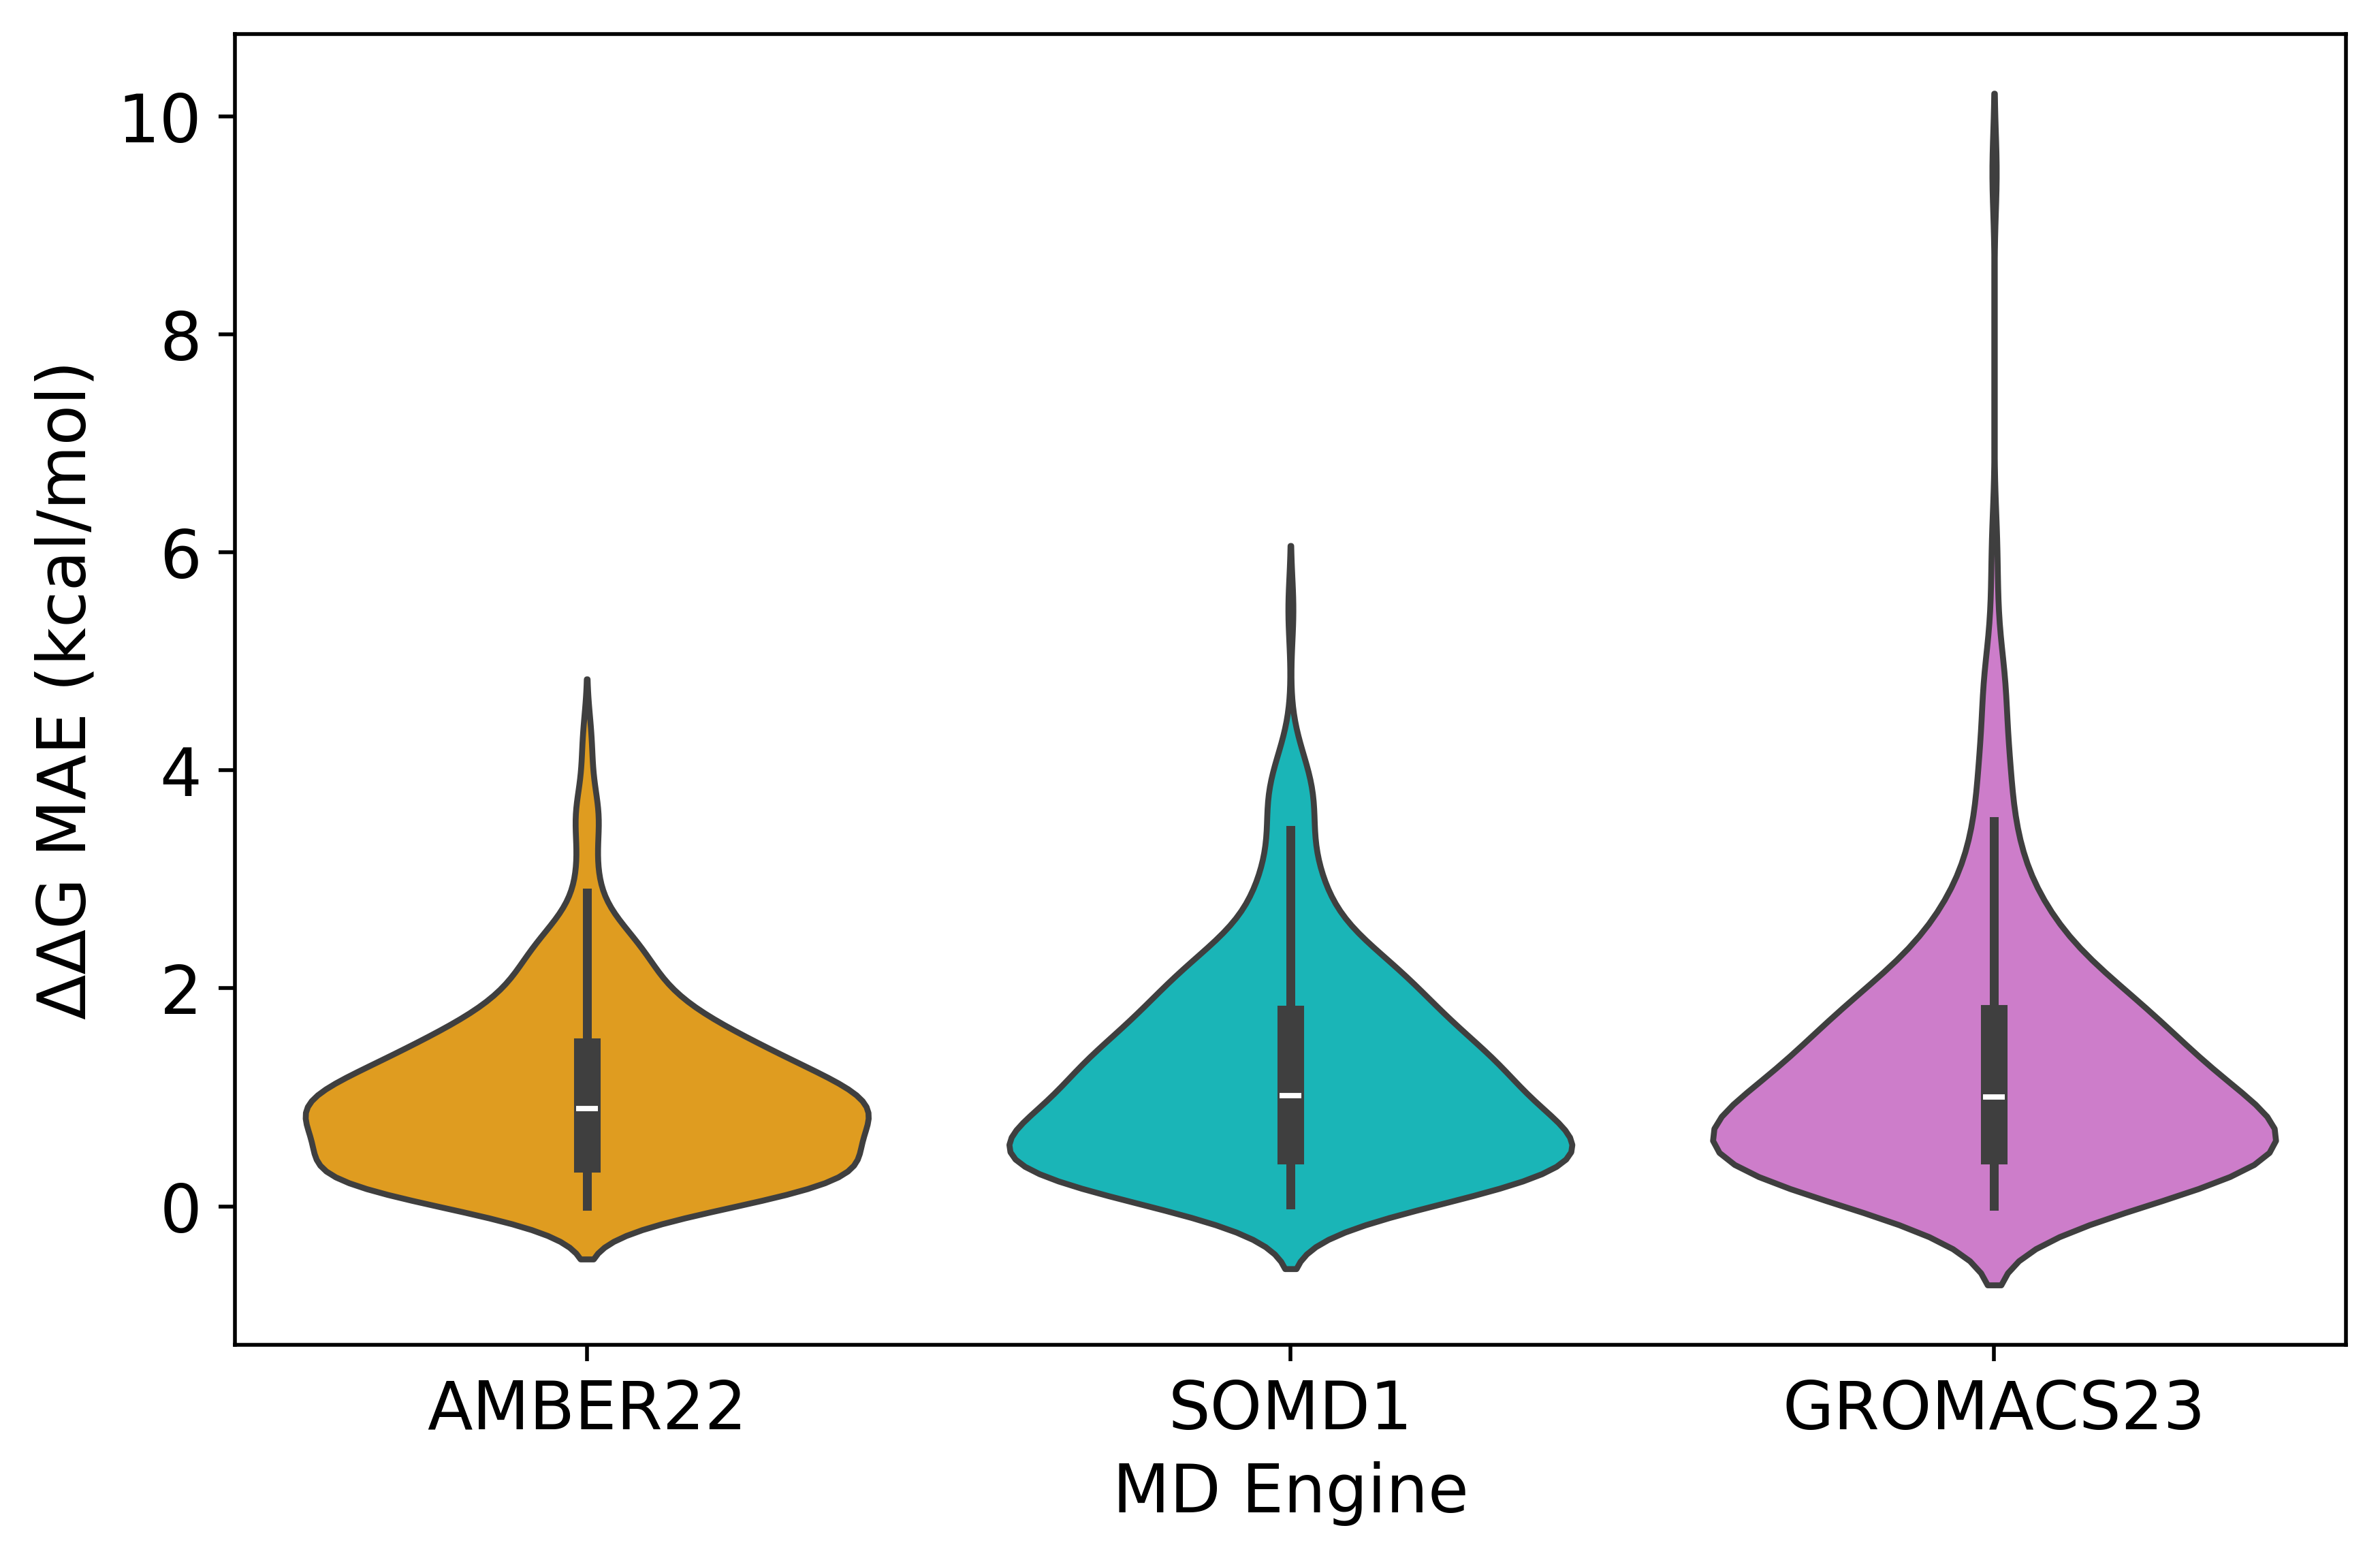

In [38]:
# violin plots
# after running the cell above, for plotting either the MAE or SEM depending
data = {"engine": [f"{eng_dict_name[eng1]}"]*len(first_err_vals) + [f"{eng_dict_name[eng2]}"]*len(second_err_vals) + [f"{eng_dict_name[eng3]}"]*len(third_err_vals),
        "error": flatten_comprehension([first_err_vals, second_err_vals, third_err_vals])
        }

df = pd.DataFrame(data)
# print(df[df["engine"] == "SOMD1"]["error"].mean())

fig, ax = plt.subplots(figsize=(8, 5), dpi=500)
sns.violinplot(x="engine", y="error", data=df, inner="box", palette=col_dict)

# plt.title(f"{stats_name} Distribution for Different MD Engines across all protein systems")
plt.tick_params(axis="x", labelsize=14, rotation=0)
plt.tick_params(axis="y", labelsize=14, rotation=0)
plt.xlabel("MD Engine", size=14)
plt.ylabel(f"{stats_name} (kcal/mol)", size=14)

In [ ]:
# Plot the distribution of the MSE (must be adjusted in the earlier cell)
plt.hist(first_err_vals, density=True, color=pipeline.analysis.set_colours()[eng1], label=f"{eng_dict_name[eng1]},\n$p$ = {_stats.kstest(np.array(first_err_vals), 'norm')[1]:.2}", alpha=0.4)
plt.hist(second_err_vals, density=True, color=pipeline.analysis.set_colours()[eng2], label=f"{eng_dict_name[eng2]},\n$p$ = {_stats.kstest(np.array(second_err_vals), 'norm')[1]:.2}", alpha=0.4)
plt.hist(third_err_vals, density=True, color=pipeline.analysis.set_colours()[eng3], label=f"{eng_dict_name[eng3]},\n$p$ = {_stats.kstest(np.array(third_err_vals), 'norm')[1]:.2}", alpha=0.4)
plt.legend(loc="upper right")
plt.xlabel(f"$\Delta\Delta G$ MSE (kcal/mol)")
plt.ylabel("Density")
# plt.title("All proteins")
# plot for all proteins, and ind proteins too
# also check sem error sig again

In [40]:
# Below calculates the MAD between the engines
engines = ana_obj.engines

df = pd.DataFrame(columns=engines, index=engines)
df_err = pd.DataFrame(columns=engines, index=engines)
df_ci = pd.DataFrame(columns=engines, index=engines)

# iterate compared to experimental
for eng1, eng2 in it.product(engines, engines):

    res = stats_engines.compute_stats(
        x=eng_list_dict[eng2], y=eng_list_dict[eng1], statistic="MUE")

    mean_absolute_error = res[0]  # the computed statistic
    err = res[1]  # the stderr from bootstrapping
    ci = res[2]

    # loc index, column
    df.loc[eng2, eng1] = mean_absolute_error
    df_err.loc[eng2, eng1] = err
    df_ci.loc[eng2, eng1] = ci

mad = (df,df_err,df_ci)
mad[0].update(mad[0].applymap(lambda x: f"" if x == 0 else f"{x:.2f}"))
mad[2].update(mad[2].applymap(lambda x: f"" if x[0]
              == 0 else f"({x[0]:.2f}, {x[1]:.2f})"))
df_val = mad[0].astype(str) + " " + mad[2].astype(str)
df_val

,AMBER,SOMD,GROMACS
AMBER,,"0.79 (0.70, 0.88)","0.96 (0.86, 1.07)"
SOMD,"0.79 (0.70, 0.88)",,"1.00 (0.88, 1.12)"
GROMACS,"0.96 (0.86, 1.07)","1.00 (0.88, 1.11)",


In [ ]:
# comparing to the literature results for plotting
# read in the files - these have already been preprocessed to match ligand names with those in the present dataset, as well as analysed with cinnabar.

# obtain the literature results

fepplus_ligs_dict = {}
fepplus_perts_dict = {}
hahn_ligs_dict = {}
hahn_perts_dict = {}
openfe_ligs_dict = {}
openfe_perts_dict = {}

for prot in ana_obj_dict:

    fepplus_perts_dict[prot] = {f'{row["lig_0"]}~{row["lig_1"]}':(row["freenrg"],row["error"]) for i,row in pd.read_csv(f"{main_dir}/inputs/other_computed/{prot}_perts_file_fepplus.csv").iterrows()}
    fepplus_ligs_dict[prot] = {row["ligand"]:(row["freenrg"],row["error"]) for i,row in pd.read_csv(f"{main_dir}/inputs/other_computed/{prot}_ligs_file_fepplus.csv").iterrows()}

    hahn_perts_dict[prot] = {f'{row["lig_0"]}~{row["lig_1"]}':(row["freenrg"],row["error"]) for i,row in pd.read_csv(f"{main_dir}/inputs/other_computed/{prot}_perts_file_hahn.csv").iterrows()}
    hahn_ligs_dict[prot] = {row["ligand"]:(row["freenrg"],row["error"]) for i,row in pd.read_csv(f"{main_dir}/inputs/other_computed/{prot}_ligs_file_hahn.csv").iterrows()}

    openfe_perts_dict[prot] = {f'{row["lig_0"]}~{row["lig_1"]}':(row["freenrg"],row["error"]) for i,row in pd.read_csv(f"{main_dir}/inputs/other_computed/{prot}_perts_file_openfe.csv").iterrows()}
    openfe_ligs_dict[prot] = {row["ligand"]:(row["freenrg"],row["error"]) for i,row in pd.read_csv(f"{main_dir}/inputs/other_computed/{prot}_ligs_file_openfe.csv").iterrows()}


In [ ]:
# calculate correlation statistics with gaussian noise
ana_obj_dict = network_dict["lomap"]
stats_name = "KTAU"
print(stats_name)

val_dict = {}

for prot in ana_obj_dict:
    print(prot)

    ana_obj = ana_obj_dict[prot]["plain"]

    val_dict[prot] = {}

    exper_dict = ana_obj.exper_val_dict

    for lit_perts_dict, name in zip([ana_obj.cinnabar_calc_val_dict["AMBER"], ana_obj.cinnabar_calc_val_dict["SOMD"], ana_obj.cinnabar_calc_val_dict["GROMACS"], openfe_ligs_dict[prot], hahn_ligs_dict[prot], fepplus_ligs_dict[prot]], ["AMBER", "SOMD", "GROMACS", "openfe", "hahn", "fepplus"]):
        # for lit_perts_dict, name in zip([openfe_perts_dict[prot], hahn_perts_dict[prot], fepplus_perts_dict[prot]], ["openfe", "hahn", "fepplus"]):  #
        print(name)

        x = []
        y = []
        xerr = []
        yerr = []

        exper_pert_dict = {}
        avg = np.mean([val[0] for val in exper_dict.values()])
        for lig in exper_dict:
            exper_pert_dict[lig] = (
                exper_dict[lig][0] - avg, exper_dict[lig][1])

        for pert in ana_obj.ligands:  # perturbations
            try:
                x.append(lit_perts_dict[pert][0])
                xerr.append(lit_perts_dict[pert][1])
                y.append(exper_pert_dict[pert][0])
                yerr.append(exper_pert_dict[pert][1])
            except:
                print(pert)

        # calculate statistics
        res = parametric_statistics.gaussian_noise_stats(
            x=x, xerr=xerr, y=y, yerr=yerr, repeats=10000, stats_name=stats_name)

        val_dict[prot][eng_dict_name[name]] = (
            res[0],
            res[1],
            res[2],
        )

df = pd.DataFrame(val_dict)
# df.to_markdown()
df = df.applymap(lambda x: f"{x[0]:.2f} ({x[2][0]:.2f},{x[2][1]:.2f})")
df

In [ ]:
# two sample t test for ktau
for prot in ana_obj_dict:
    print(prot)
    for eng, eng1, in it.product(["AMBER22", "SOMD1","GROMACS23"],["Ross et al.","Hahn et al.","OpenFE"]):

        t = (val_dict[prot][eng1][0] - val_dict[prot][eng][0]) / ( np.sqrt( (val_dict[prot][eng1][1] / 1000) + (val_dict[prot][eng][1]  / 1000)))
        print(eng, eng1, t)

# for 0.05 p value, and 10k bootstraps, the critical t value is 1.962
# if t value is greater than critical, the null hypothesis is rejected

[Text(0, 0, 'TYK2'),
 Text(1, 0, 'MCL1'),
 Text(2, 0, 'P38α'),
 Text(3, 0, 'SYK'),
 Text(4, 0, 'HIF2A'),
 Text(5, 0, 'CMET')]

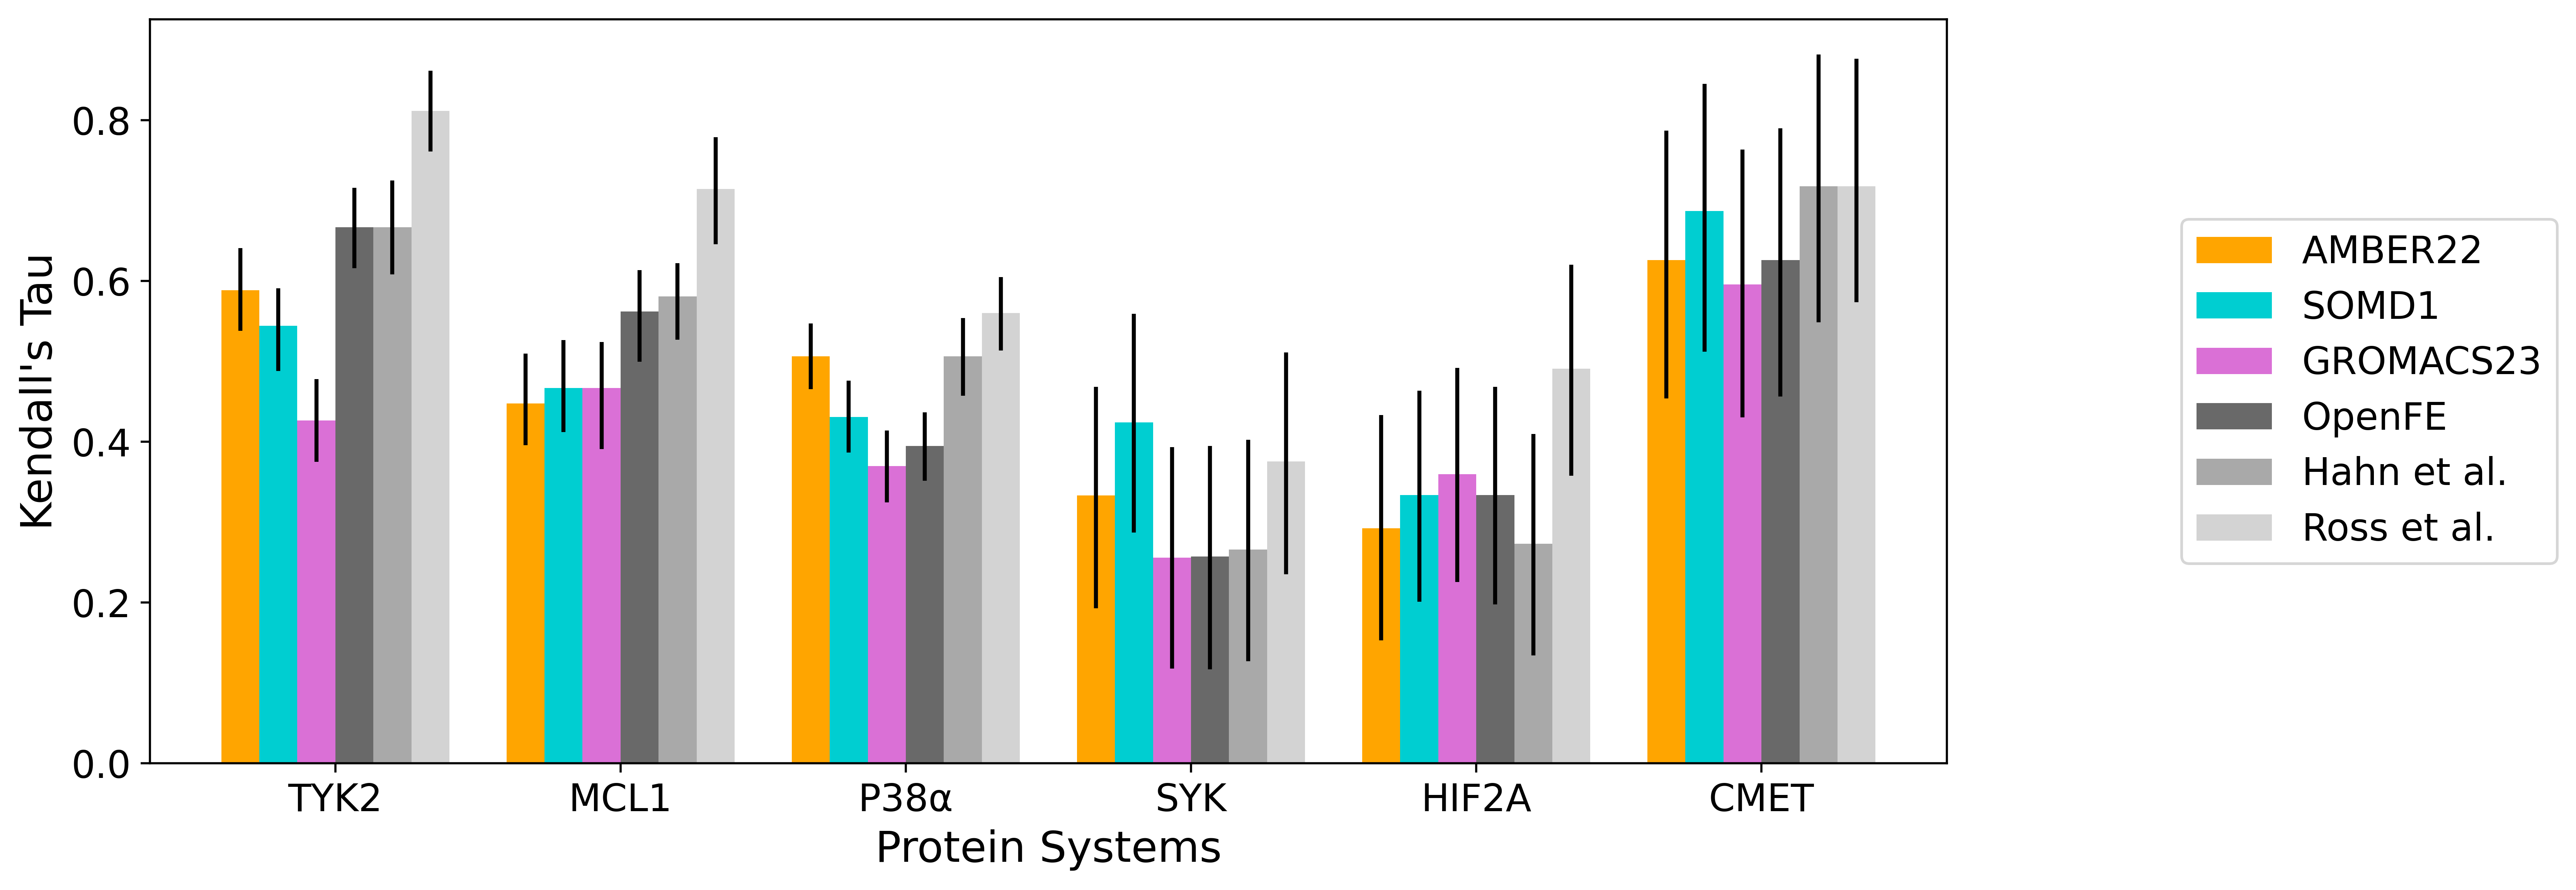

In [82]:
val_res = pd.DataFrame(val_dict).T.map(lambda x: x[0])
fig, ax = plt.subplots(figsize=(12, 5), dpi=500)

df_err = pd.DataFrame(val_dict).T.map(lambda x: x[2])
df_lower = val_res - df_err.applymap(lambda x: x[0])
df_upper = df_err.applymap(lambda x: x[1]) - val_res
# df_upper["SOMD1"]["syk"] = 0.0
df_err = np.stack([df_lower.T.values, df_upper.T.values], axis=1)

val_res.plot.bar(color=col_dict,
                        yerr=df_err,
                        xlabel = "Protein Systems",
                        ylabel=f"Kendall's Tau",
                        ax=ax,
                        width=0.8,  # Adjust the width of the bars
                        )
ax.legend(loc='center right', bbox_to_anchor=( # lower center (0.5,1)
    1.35, 0.5), #fancybox=True, shadow=True
    )
ax.set_xticklabels(#[],
    [val for val in prot_dict_name.values()],
                    rotation=0
    )
# ax.set_ylabel("Kendall's Tau")

In [ ]:
# calculate perturbation statistics for all proteins together
# comments to plot ligands
stats_name = "RMSE"
print(stats_name)

if stats_name == "MAE":
    cinn_stats_name = "MUE"
elif stats_name == "RMSE":
    cinn_stats_name = "RMSE"

val_dict_all = {}
val_dict_all["all"] = {}

for eng in ana_obj.engines:  #

    x = []
    y = []
    xerr = []
    yerr = []

    for prot in ana_obj_dict:

        ana_obj = ana_obj_dict[prot]["plain"]

        exper_dict = ana_obj.exper_val_dict

        perturbations = []
        excl = 0
        incl = 0
        for pert in ana_obj._perturbations_dict[eng]:
            try:
                if str(ana_obj.calc_pert_dict[eng][pert][0]) != "nan" and "Intermediate" not in pert:
                    perturbations.append(pert)
            except:
                pass

        exper_pert_dict = make_dict.exper_from_perturbations(
            exper_dict, perturbations)

        for pert in perturbations:
            try:
                x.append(ana_obj.calc_pert_dict[eng][pert][0])
                xerr.append(ana_obj.calc_pert_dict[eng][pert][1])
                y.append(exper_pert_dict[pert][0])
                yerr.append(exper_pert_dict[pert][1])
            except:
                print(pert)

    res = stats_engines.compute_stats(
        x=x, xerr=xerr, y=y, yerr=yerr, statistic=cinn_stats_name)

    val_dict_all["all"][eng_dict_name[eng]] = (
        res[0],
        res[1],
        res[2],
    )

for lit_perts_dict, name in zip([openfe_perts_dict, hahn_perts_dict, fepplus_perts_dict], ["openfe", "hahn", "fepplus"]): 

    print(name)

    x = []
    y = []
    xerr = []
    yerr = []

    for prot in ana_obj_dict:
        print(prot)

        ana_obj = ana_obj_dict[prot]["plain"]
        exper_dict = ana_obj.exper_val_dict

        perturbations = []
        excl = 0
        incl = 0
        for pert in lit_perts_dict[prot]:
            if pert.split("~")[0] in exper_dict.keys() and pert.split("~")[1] in exper_dict.keys():
                perturbations.append(pert)

        exper_pert_dict = make_dict.exper_from_perturbations(
            exper_dict, perturbations)

        for pert in perturbations:
            if pert in lit_perts_dict[prot].keys():
                x.append(lit_perts_dict[prot][pert][0])
                xerr.append(lit_perts_dict[prot][pert][1])
                y.append(exper_pert_dict[pert][0])
                yerr.append(exper_pert_dict[pert][1])

    res = stats_engines.compute_stats(
        x=x, xerr=xerr, y=y, yerr=yerr, statistic=cinn_stats_name)

    val_dict_all["all"][eng_dict_name[name]] = (
        res[0],
        res[1],
        res[2],
    )

df = pd.DataFrame(val_dict_all)
# df.to_markdown()
df = df.applymap(lambda x: f"{x[0]:.2f} ({x[2][0]:.2f},{x[2][1]:.2f})")
df

[Text(0, 0, '')]

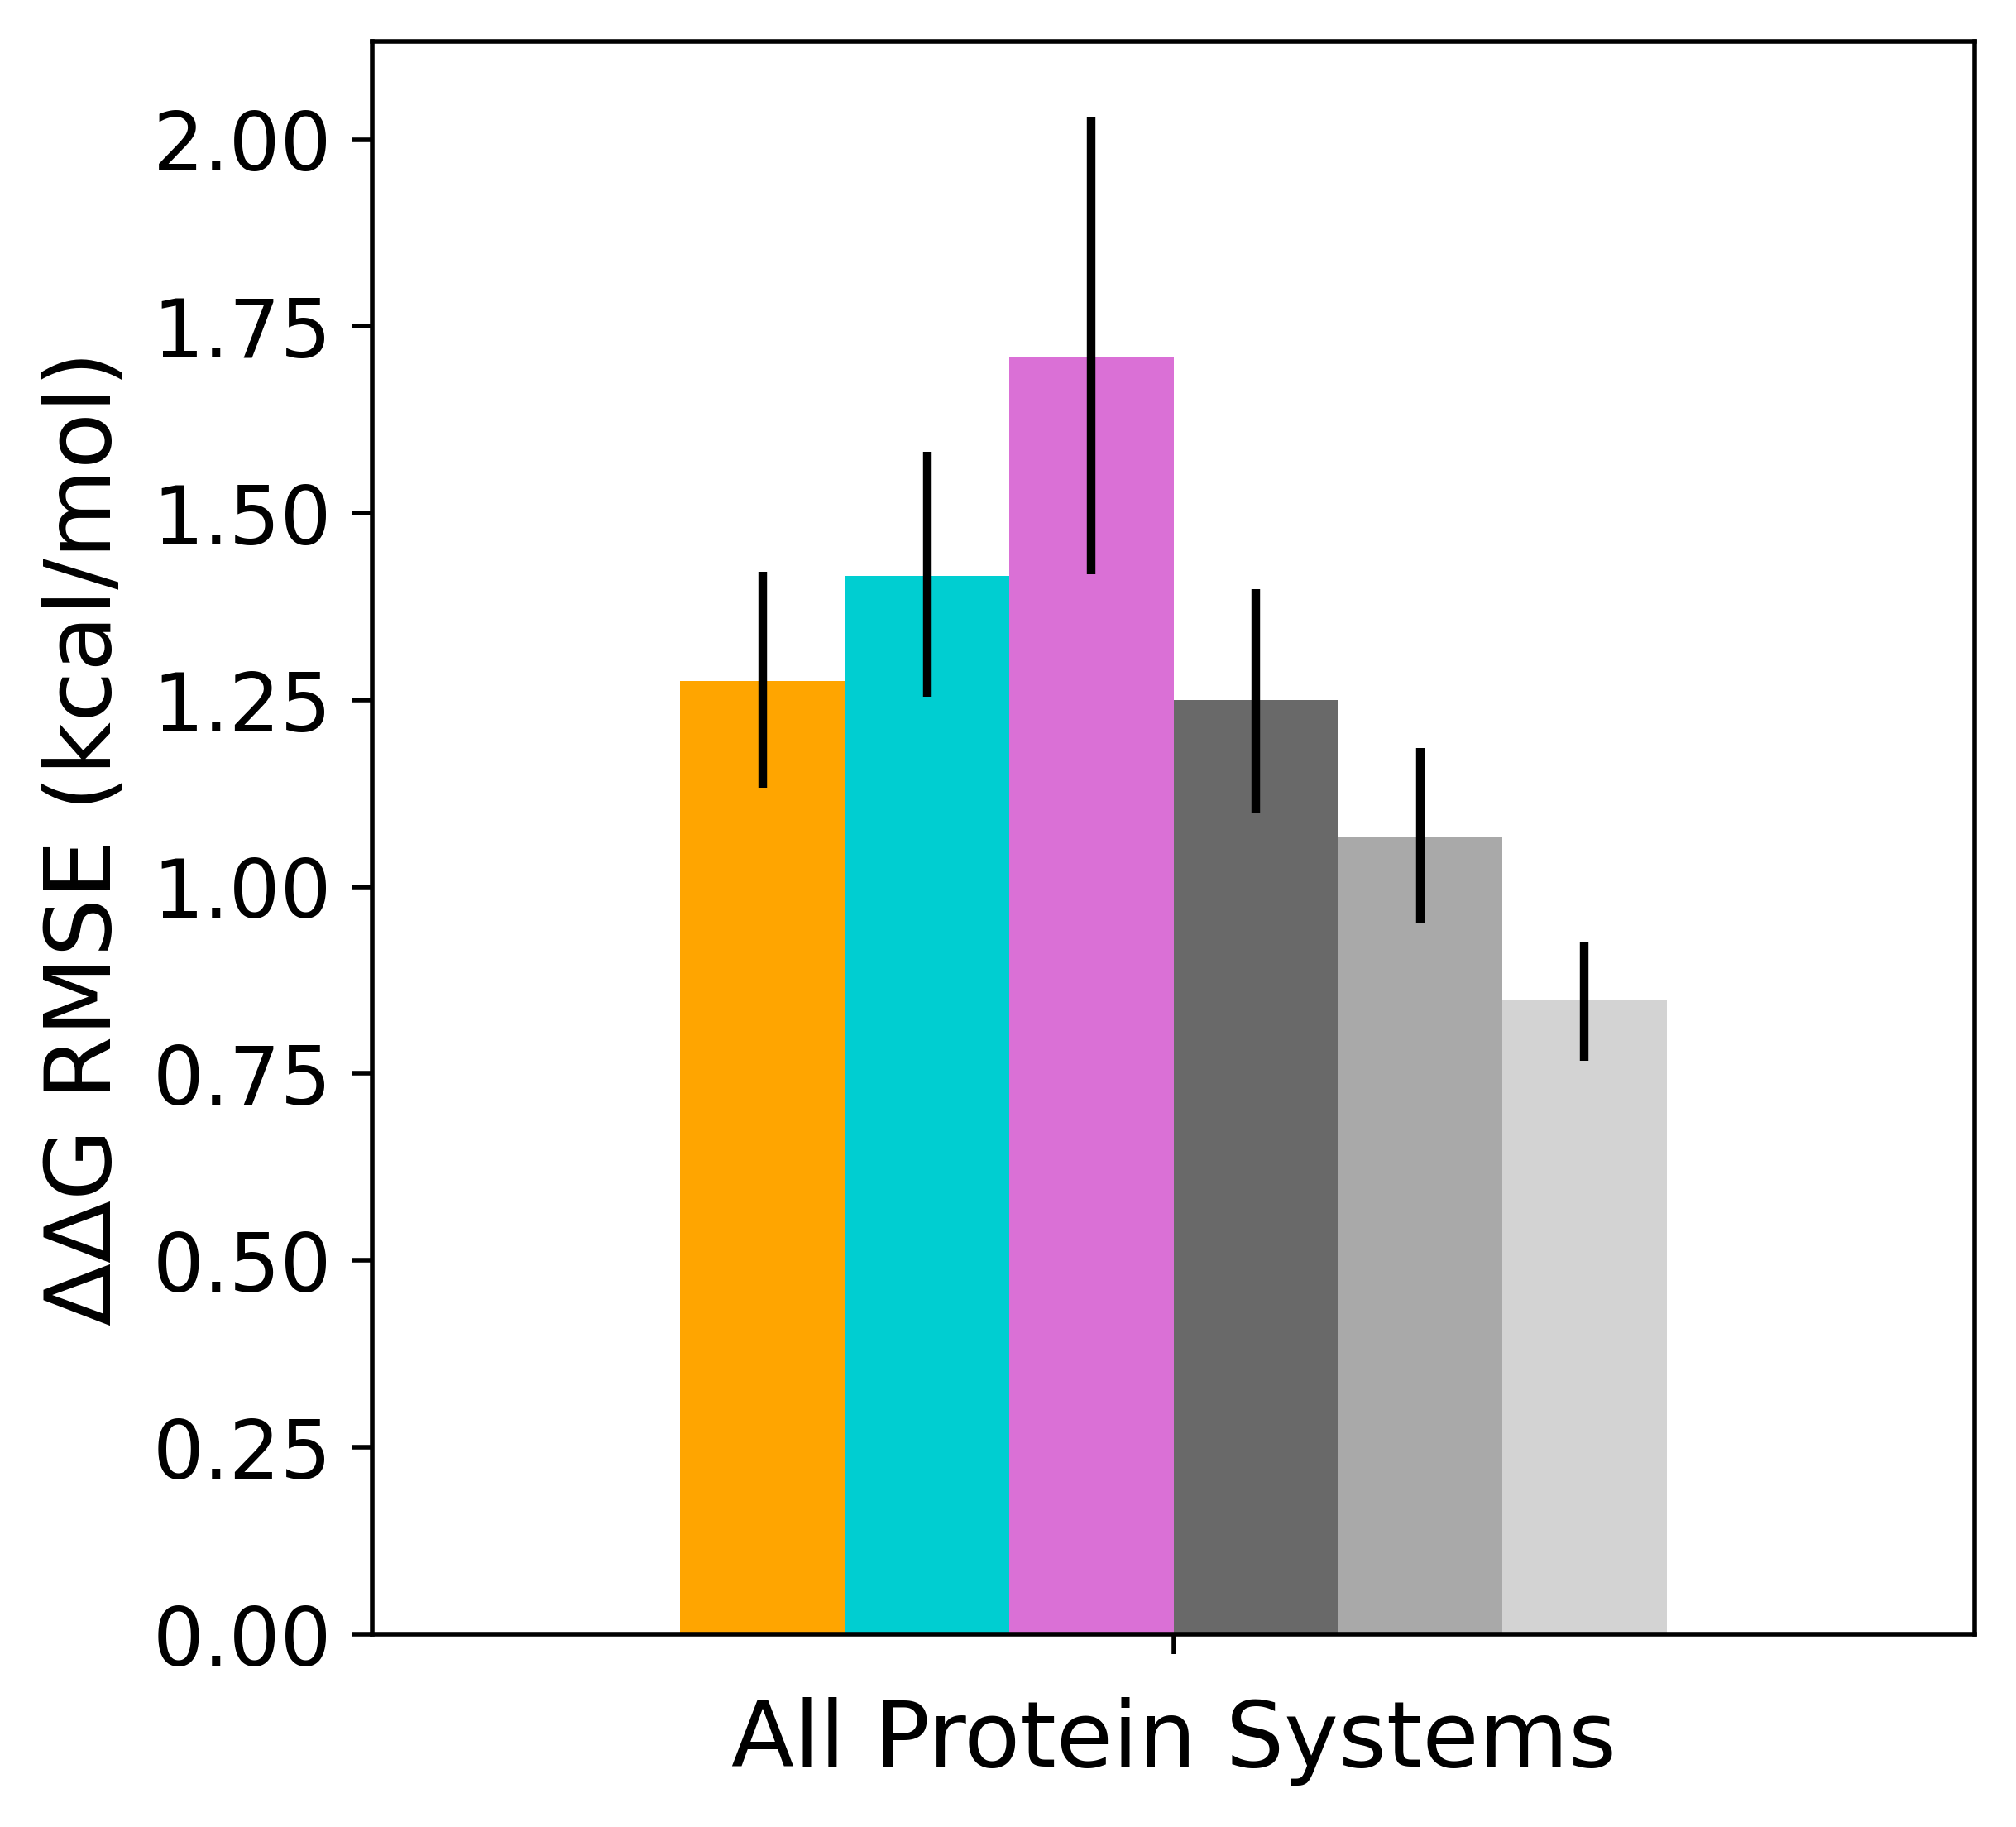

In [84]:
val_res = pd.DataFrame(val_dict_all).T.map(lambda x: x[0])
fig, ax = plt.subplots(figsize=(5, 5), dpi=500)

df_err = pd.DataFrame(val_dict_all).T.map(lambda x: x[2])
df_lower = val_res - df_err.applymap(lambda x: x[0])
df_upper = df_err.applymap(lambda x: x[1]) - val_res
df_err = np.stack([df_lower.T.values, df_upper.T.values], axis=1)

val_res.plot.bar(color=col_dict,
                        yerr=df_err,
                        xlabel = "All Protein Systems",
                 ylabel=f"ΔΔG RMSE (kcal/mol)",
                        ax=ax,
                        width=0.8, 
                        legend=False
                        )
ax.set_xticklabels([]
    )

In [ ]:
# plotting statistics for the different networks

plotting_dict = {}

stats_name = "Kendall's Tau" # "ΔG MAE (kcal/mol)", "ΔΔG MAE (kcal/mol)", "$r^2$", "Kendall's Tau"
print(stats_name)

for network in ["lomap", "rbfenn", "flare",  "combined", "lomap-a-optimal", "lomap-d-optimal", "rbfenn-a-optimal", "rbfenn-d-optimal"]: # adjust as needed
    plotting_dict[network] = {}

    for prot in ["tyk2", "mcl1", "p38"]: # ana_obj_dict.keys():
        print(network, prot)
        plotting_dict[network][prot] = {}

        ana_obj = network_dict[network][prot]["plain"]

        try:
            # print(len(ana_obj.perturbations))

            if stats_name == "ΔG MAE (kcal/mol)":
                func = ana_obj.calc_mae_engines
                stats_string_all = ""
                pert_val = "val"
                mae = func(pert_val=pert_val, recalculate=True)
            elif stats_name == "ΔΔG MAE (kcal/mol)":
                func = ana_obj.calc_mae_engines
                stats_string_all = ""
                pert_val = "pert"
                mae = func(pert_val=pert_val, recalculate=True)
                
            elif stats_name == "$r^2$":
                _stats_name = "R2"
            elif stats_name == "Kendall's Tau":
                _stats_name = "KTAU"

            else:
                print("no")

            if stats_name == "ΔG MAE (kcal/mol)" or stats_name == "ΔΔG MAE (kcal/mol)":
                for eng in ana_obj.engines:
                    plotting_dict[network][prot][eng] = (
                        mae[0][eng]["experimental"],
                        mae[1][eng]["experimental"],
                        mae[2][eng]["experimental"],
                    )
            elif stats_name == "$r^2$" or stats_name == "Kendall's Tau":
                for lit_perts_dict, name in zip([ana_obj.cinnabar_calc_val_dict["AMBER"], ana_obj.cinnabar_calc_val_dict["SOMD"], ana_obj.cinnabar_calc_val_dict["GROMACS"]], ["AMBER", "SOMD", "GROMACS"]):
                    print(name)

                    x = []
                    y = []
                    xerr = []
                    yerr = []

                    exper_pert_dict = ana_obj.normalised_exper_val_dict

                    for pert in ana_obj.ligands:  # perturbations
                        try:
                            if "Intermediate" in pert:
                                pass
                            else:
                                x.append(lit_perts_dict[pert][0])
                                xerr.append(lit_perts_dict[pert][1])
                                y.append(exper_pert_dict[pert][0])
                                yerr.append(exper_pert_dict[pert][1])
                        except:
                            print(pert)

                    # calculate statistics
                    res = parametric_statistics.gaussian_noise_stats(
                        x=x, xerr=xerr, y=y, yerr=yerr, repeats=10000, stats_name=_stats_name)

                    plotting_dict[network][prot][name] = (
                        res[0],
                        res[1],
                        res[2],
                    )
        except Exception as e:
            print(e)
            for eng in network_dict["lomap"]["tyk2"]["plain"].engines:
                plotting_dict[network][prot][eng] = (0,0,[0,0])

Text(0.5, 1.0, 'SOMD1')

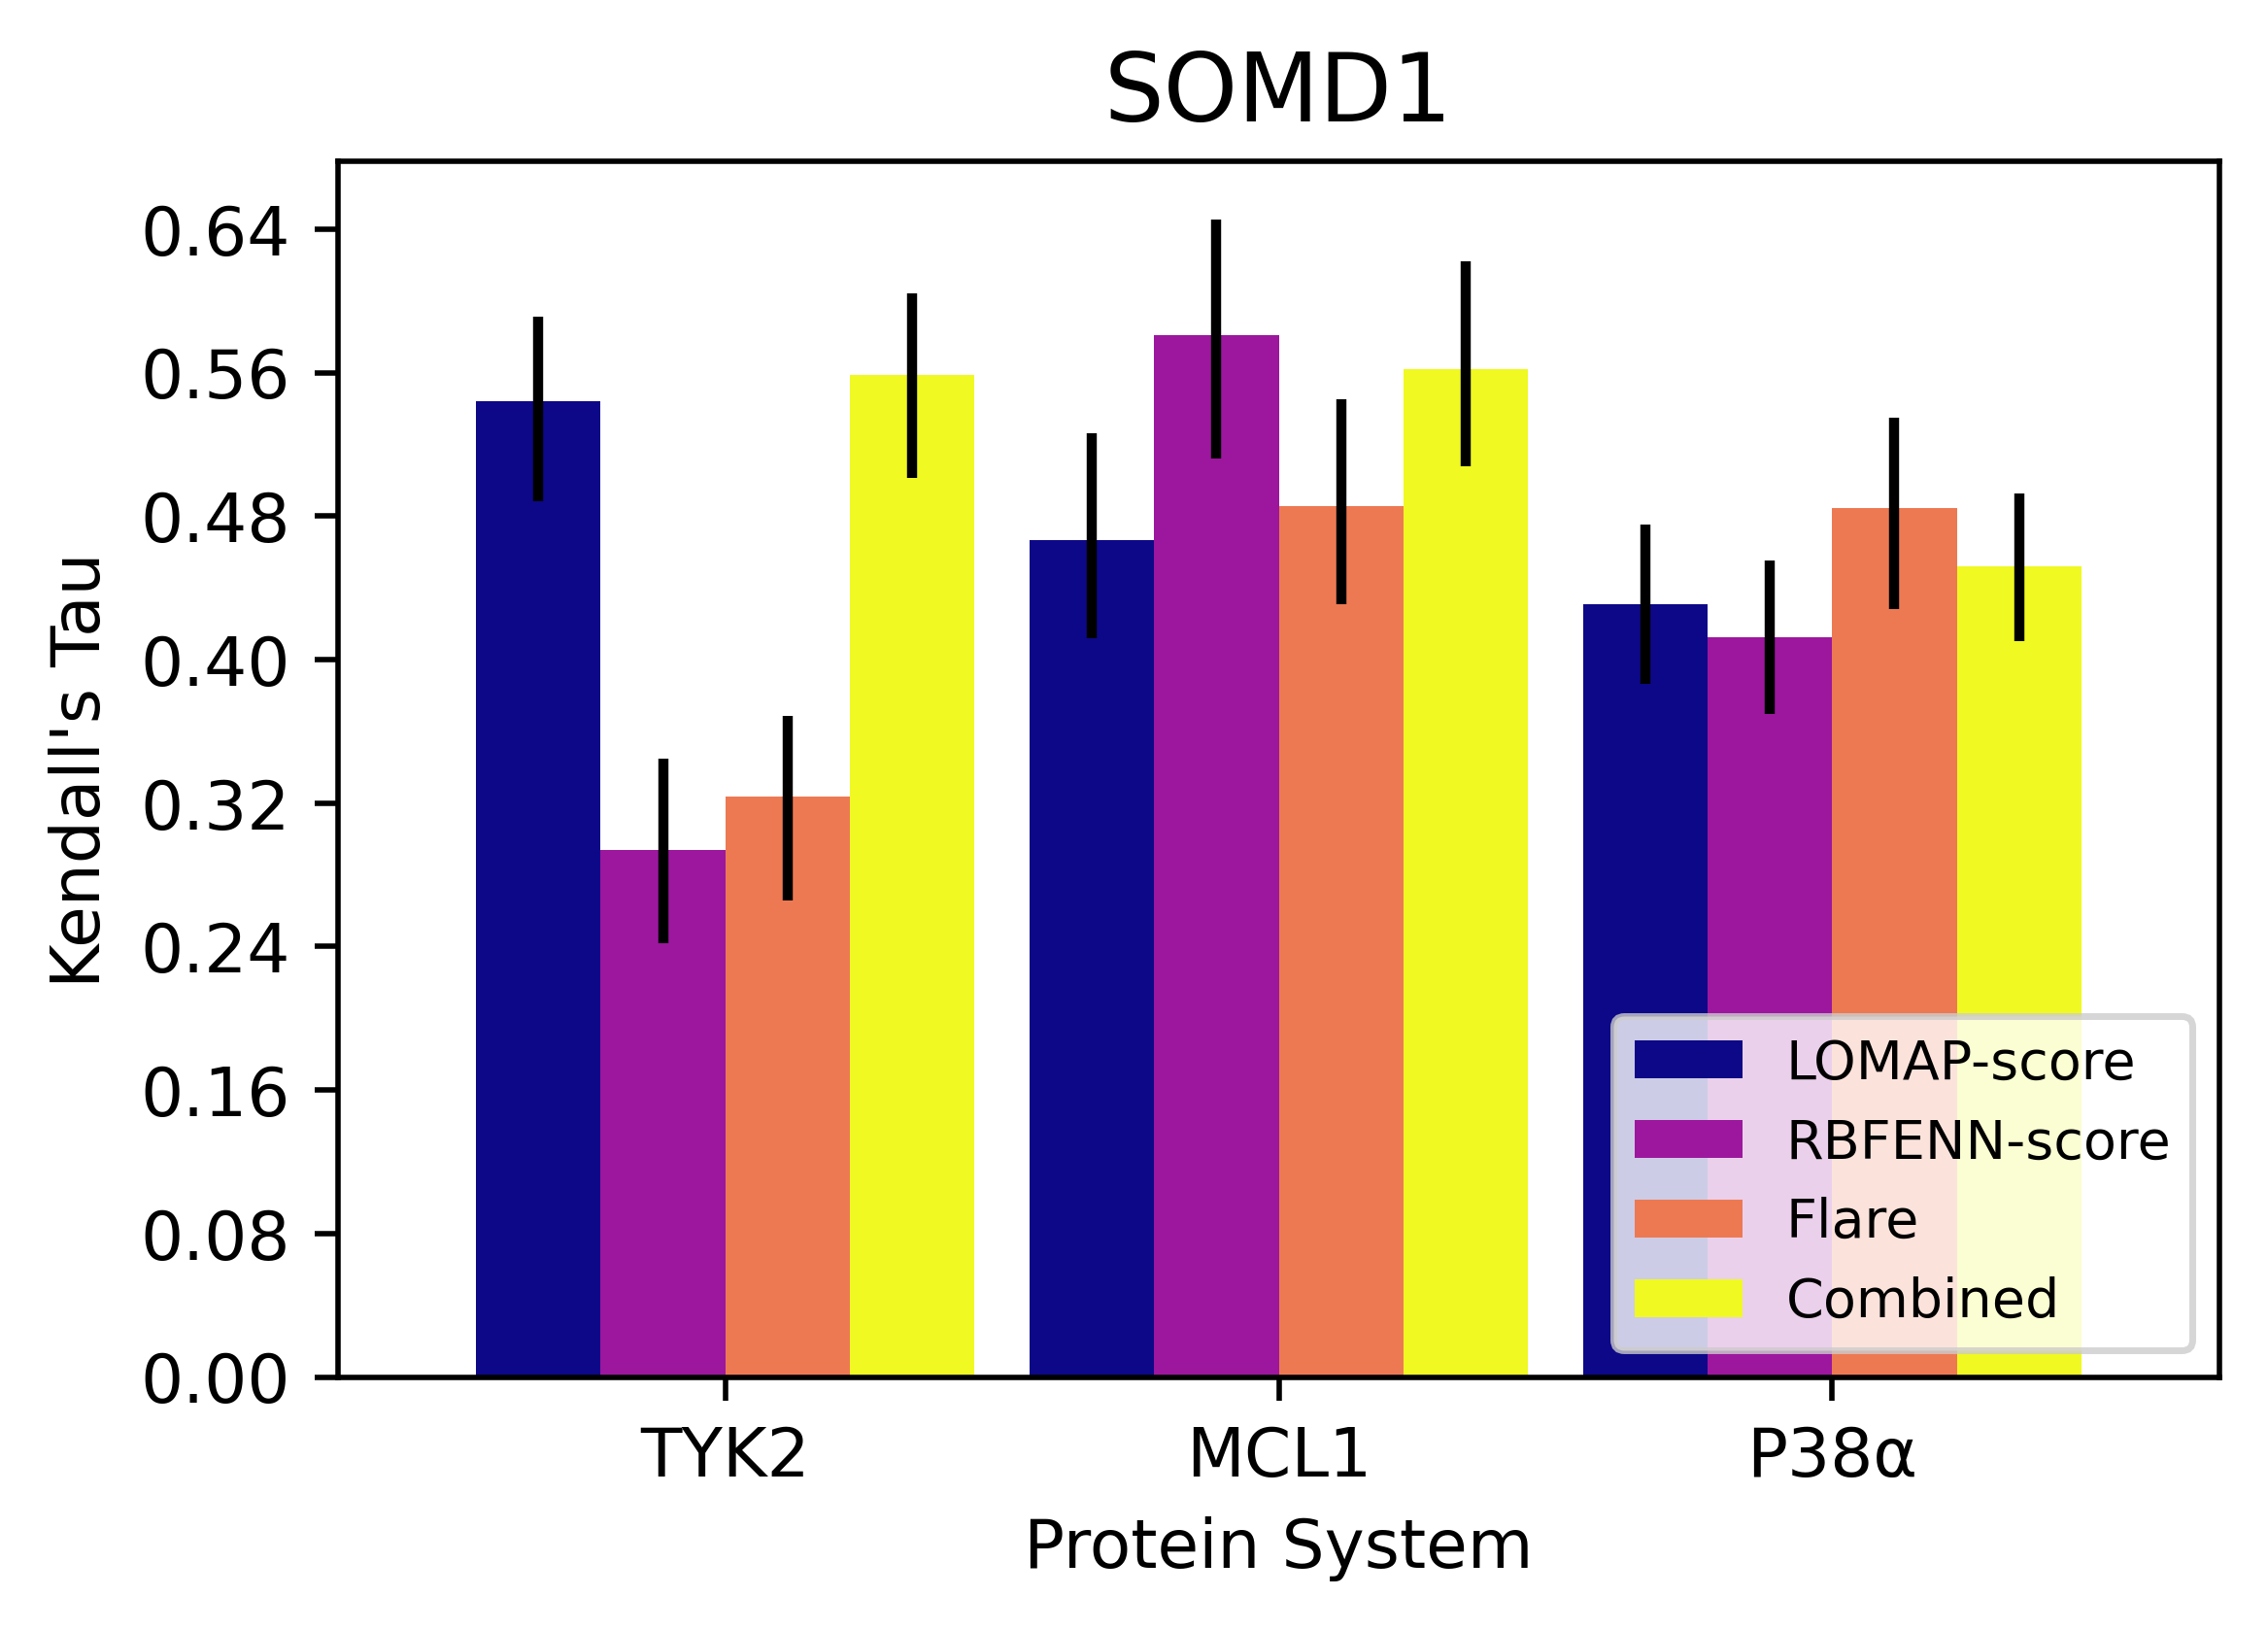

In [87]:
# for a specific engine
# can adjust which are getting plotted in reduce

fig, ax = plt.subplots(figsize=(5, 3.25), dpi=500)
plt.xlim = ()
plt.ylim = ()

ana_obj = network_dict["lomap"]["tyk2"]["plain"]
engine = "SOMD"

df_lomap = (
    pd.DataFrame(plotting_dict["lomap"])
    .applymap(lambda x: x[0])
    .T.rename(prot_dict_name)
    .drop(labels=[eng for eng in ana_obj.engines if eng != engine], axis=1)
    .rename({engine: "LOMAP-score"}, axis=1)
)
df_rbfenn = (
    pd.DataFrame(plotting_dict["rbfenn"])
    .applymap(lambda x: x[0])
    .T.rename(prot_dict_name)
    .drop(labels=[eng for eng in ana_obj.engines if eng != engine], axis=1)
    .rename({engine: "RBFENN-score"}, axis=1)
)
df_flare = (
    pd.DataFrame(plotting_dict["flare"])
    .applymap(lambda x: x[0])
    .T.rename(prot_dict_name)
    .drop(labels=[eng for eng in ana_obj.engines if eng != engine], axis=1)
    .rename({engine: "Flare"}, axis=1)
)
df_lomapa = (
    pd.DataFrame(plotting_dict["lomap-a-optimal"])
    .applymap(lambda x: x[0])
    .T.rename(prot_dict_name)
    .drop(labels=[eng for eng in ana_obj.engines if eng != engine], axis=1)
    .rename({engine: "LOMAP-A-optimal"}, axis=1)
)
df_lomapd = (
    pd.DataFrame(plotting_dict["lomap-d-optimal"])
    .applymap(lambda x: x[0])
    .T.rename(prot_dict_name)
    .drop(labels=[eng for eng in ana_obj.engines if eng != engine], axis=1)
    .rename({engine: "LOMAP-D-optimal"}, axis=1)
)
df_rbfenna = (
    pd.DataFrame(plotting_dict["rbfenn-a-optimal"])
    .applymap(lambda x: x[0])
    .T.rename(prot_dict_name)
    .drop(labels=[eng for eng in ana_obj.engines if eng != engine], axis=1)
    .rename({engine: "RBFENN-A-optimal"}, axis=1)
)
df_rbfennd = (
    pd.DataFrame(plotting_dict["rbfenn-d-optimal"])
    .applymap(lambda x: x[0])
    .T.rename(prot_dict_name)
    .drop(labels=[eng for eng in ana_obj.engines if eng != engine], axis=1)
    .rename({engine: "RBFENN-D-optimal"}, axis=1)
)
df_combined = (
    pd.DataFrame(plotting_dict["combined"])
    .applymap(lambda x: x[0])
    .T.rename(prot_dict_name)
    .drop(labels=[eng for eng in ana_obj.engines if eng != engine], axis=1)
    .rename({engine: "Combined"}, axis=1)
)
df = reduce(
    lambda left, right: pd.merge(left, right, left_index=True, right_index=True),
    # , df_lomap, df_lomapa, df_lomapd, df_rbfenn, df_rbfenna, df_rbfennd
    [df_lomap, df_rbfenn, df_flare, df_combined]
    # [df_lomap,  df_lomapa, df_lomapd, df_rbfenn, df_rbfenna, df_rbfennd],
)
# df.insert(0, "Kuhn et al.", [0.70, 0.94, 1.18], True) # dG
# df.insert(0, "Kuhn et al.", [0.54, 0.56, 0.54], True)  # ktau

# TODO consider error which
df_lomap = (
    pd.DataFrame(plotting_dict["lomap"])
    .applymap(lambda x: x[2])
    .T.rename(prot_dict_name)
    .drop(labels=[eng for eng in ana_obj.engines if eng != engine], axis=1)
    .rename({engine: "LOMAP-score"}, axis=1)
)
df_rbfenn = (
    pd.DataFrame(plotting_dict["rbfenn"])
    .applymap(lambda x: x[2])
    .T.rename(prot_dict_name)
    .drop(labels=[eng for eng in ana_obj.engines if eng != engine], axis=1)
    .rename({engine: "RBFENN-score"}, axis=1)
)
df_flare = (
    pd.DataFrame(plotting_dict["flare"])
    .applymap(lambda x: x[2])
    .T.rename(prot_dict_name)
    .drop(labels=[eng for eng in ana_obj.engines if eng != engine], axis=1)
    .rename({engine: "Flare"}, axis=1)
)
df_lomapa = (
    pd.DataFrame(plotting_dict["lomap-a-optimal"])
    .applymap(lambda x: x[2])
    .T.rename(prot_dict_name)
    .drop(labels=[eng for eng in ana_obj.engines if eng != engine], axis=1)
    .rename({engine: "LOMAP-A-optimal"}, axis=1)
)
df_lomapd = (
    pd.DataFrame(plotting_dict["lomap-d-optimal"])
    .applymap(lambda x: x[2])
    .T.rename(prot_dict_name)
    .drop(labels=[eng for eng in ana_obj.engines if eng != engine], axis=1)
    .rename({engine: "LOMAP-D-optimal"}, axis=1)
)
df_rbfenna = (
    pd.DataFrame(plotting_dict["rbfenn-a-optimal"])
    .applymap(lambda x: x[2])
    .T.rename(prot_dict_name)
    .drop(labels=[eng for eng in ana_obj.engines if eng != engine], axis=1)
    .rename({engine: "RBFENN-A-optimal"}, axis=1)
)
df_rbfennd = (
    pd.DataFrame(plotting_dict["rbfenn-d-optimal"])
    .applymap(lambda x: x[2])
    .T.rename(prot_dict_name)
    .drop(labels=[eng for eng in ana_obj.engines if eng != engine], axis=1)
    .rename({engine: "RBFENN-D-optimal"}, axis=1)
)
# a d optimal
df_combined = (
    pd.DataFrame(plotting_dict["combined"])
    .applymap(lambda x: x[2])
    .T.rename(prot_dict_name)
    .drop(labels=[eng for eng in ana_obj.engines if eng != engine], axis=1)
    .rename({engine: "Combined"}, axis=1)
)
df_err = reduce(
    lambda left, right: pd.merge(left, right, left_index=True, right_index=True),
    [df_lomap, df_rbfenn, df_flare, df_combined]
    # [df_lomap, df_lomapa, df_lomapd,df_rbfenn, df_rbfenna, df_rbfennd ], # df_lomap, df_rbfenn, df_flare, df_combined
)

df_low = df - df_err.map(lambda x: x[0])
df_high = df_err.map(lambda x: x[1]) - df
df_err = np.stack([df_low.T.values, df_high.T.values], axis=1)

df.plot(
    kind="bar",
    colormap="plasma",
    # color=[
    #     "mediumblue", "dodgerblue", "lightsteelblue",
    #     "darkviolet", "orchid", "thistle"
    # ],
    #     # "mediumslateblue",
    #     "darkturquoise",
    #     "paleturquoise",
    #     "cadetblue",
    #     "indigo",
    # ],  # ["mediumslateblue","indigo"],
    yerr=df_err,
    xlabel="Protein System",
    ylabel=f"{stats_name} (kcal/mol)",
    ax=ax,
    width=0.9
    # fontsize=8
)
ax.yaxis.set_major_locator(MaxNLocator(integer=False))
# ax.set_ylim([0, 2])

plt.legend(fontsize=8, loc="lower right", )#bbox_to_anchor=(0.15, 1.4))
plt.xlabel("Protein System", fontsize=10)
plt.ylabel(f"{stats_name}", fontsize=10)
plt.tick_params(axis="both", which="major", labelsize=10, rotation=0)
plt.title(f"{eng_dict_name[engine]}")
# ax.set_ylim(top=1)

In [101]:
# get the cinnabar stats into a dict
net_ana_method_dict = {"method": [], "engine": [], "protein": [], "value": []}
network = "lomap"

# to analyse the files, the network_analysis object performs cinnabar as a default.
# to analyse the network using the other methods, the functions analyse_mbarnet() and _add_fwf_path() with _get_ana_fwf() need to be used, and the results are returned in a similar dictionary to the default cinnabar results.
# an example with cinnabar is shown below:

# calculation method
# for eng in ["AMBER", "SOMD", "GROMACS"]:
#     for prot in ana_obj_dict.keys():
#         print(prot)
#         dg_list = []

#         ana_obj = network_dict[network][prot]["plain"]

#         for key in ana_obj.cinnabar_calc_val_dict[eng].keys():
#             value = abs(
#                 abs(
#                     ana_obj.cinnabar_calc_val_dict[eng][key][0]
#                     - ana_obj.cinnabar_exper_val_dict[eng][key][0]
#                 )
#             )
#             dg_list.append(value)
#             if value > 5:
#                 print(prot, eng, key, value)

#         net_ana_method_dict["method"].append(
#             ["Cinnabar" for l in range(0, len(dg_list))]
#         )
#         net_ana_method_dict["engine"].append(
#             [eng_dict_name[eng] for l in range(0, len(dg_list))]
#         )
#         net_ana_method_dict["protein"].append([prot_dict_name[prot] for val in dg_list])
#         net_ana_method_dict["value"].append([val for val in dg_list])


# for ease, the previously analysed files are read in below instead:

for eng in ["AMBER", "SOMD", "GROMACS"]:
    for prot in ana_obj_dict.keys():

        ana_obj = network_dict[network][prot]["plain"]

        dg_list = []
        df = pd.read_csv(f"{main_dir}/results/{prot}/ligands/cinnabar/{eng}_{network}_ligands.csv")
        for i,row in df.iterrows():

            value = abs(
                    row["freenrg"]
                    - ana_obj.normalised_exper_val_dict[row["ligand"]][0]
                )
            dg_list.append(value)

        net_ana_method_dict["method"].append(
            ["Cinnabar" for l in range(0, len(dg_list))]
        )
        net_ana_method_dict["engine"].append(
            [eng_dict_name[eng] for l in range(0, len(dg_list))]
        )
        net_ana_method_dict["protein"].append([prot_dict_name[prot] for val in dg_list])
        net_ana_method_dict["value"].append([val for val in dg_list])

        dg_list = []
        df = pd.read_csv(f"{main_dir}/results/{prot}/ligands/fen/{eng}_{network}_ligands.csv")
        for i,row in df.iterrows():

            value = abs(
                    row["freenrg"]
                    - ana_obj.normalised_exper_val_dict[row["ligand"]][0]
                )
            dg_list.append(value)

        net_ana_method_dict["method"].append(
            ["FEN" for l in range(0, len(dg_list))]
        )
        net_ana_method_dict["engine"].append(
            [eng_dict_name[eng] for l in range(0, len(dg_list))]
        )
        net_ana_method_dict["protein"].append([prot_dict_name[prot] for val in dg_list])
        net_ana_method_dict["value"].append([val for val in dg_list])

        dg_list = []
        df = pd.read_csv(f"{main_dir}/results/{prot}/ligands/mbarnet/{eng}_{network}_ligands.csv")
        for i,row in df.iterrows():

            value = abs(
                    row["freenrg"]
                    - ana_obj.normalised_exper_val_dict[row["ligand"]][0]
                )
            dg_list.append(value)

        net_ana_method_dict["method"].append(
            ["MBARNet" for l in range(0, len(dg_list))]
        )
        net_ana_method_dict["engine"].append(
            [eng_dict_name[eng] for l in range(0, len(dg_list))]
        )
        net_ana_method_dict["protein"].append([prot_dict_name[prot] for val in dg_list])
        net_ana_method_dict["value"].append([val for val in dg_list])



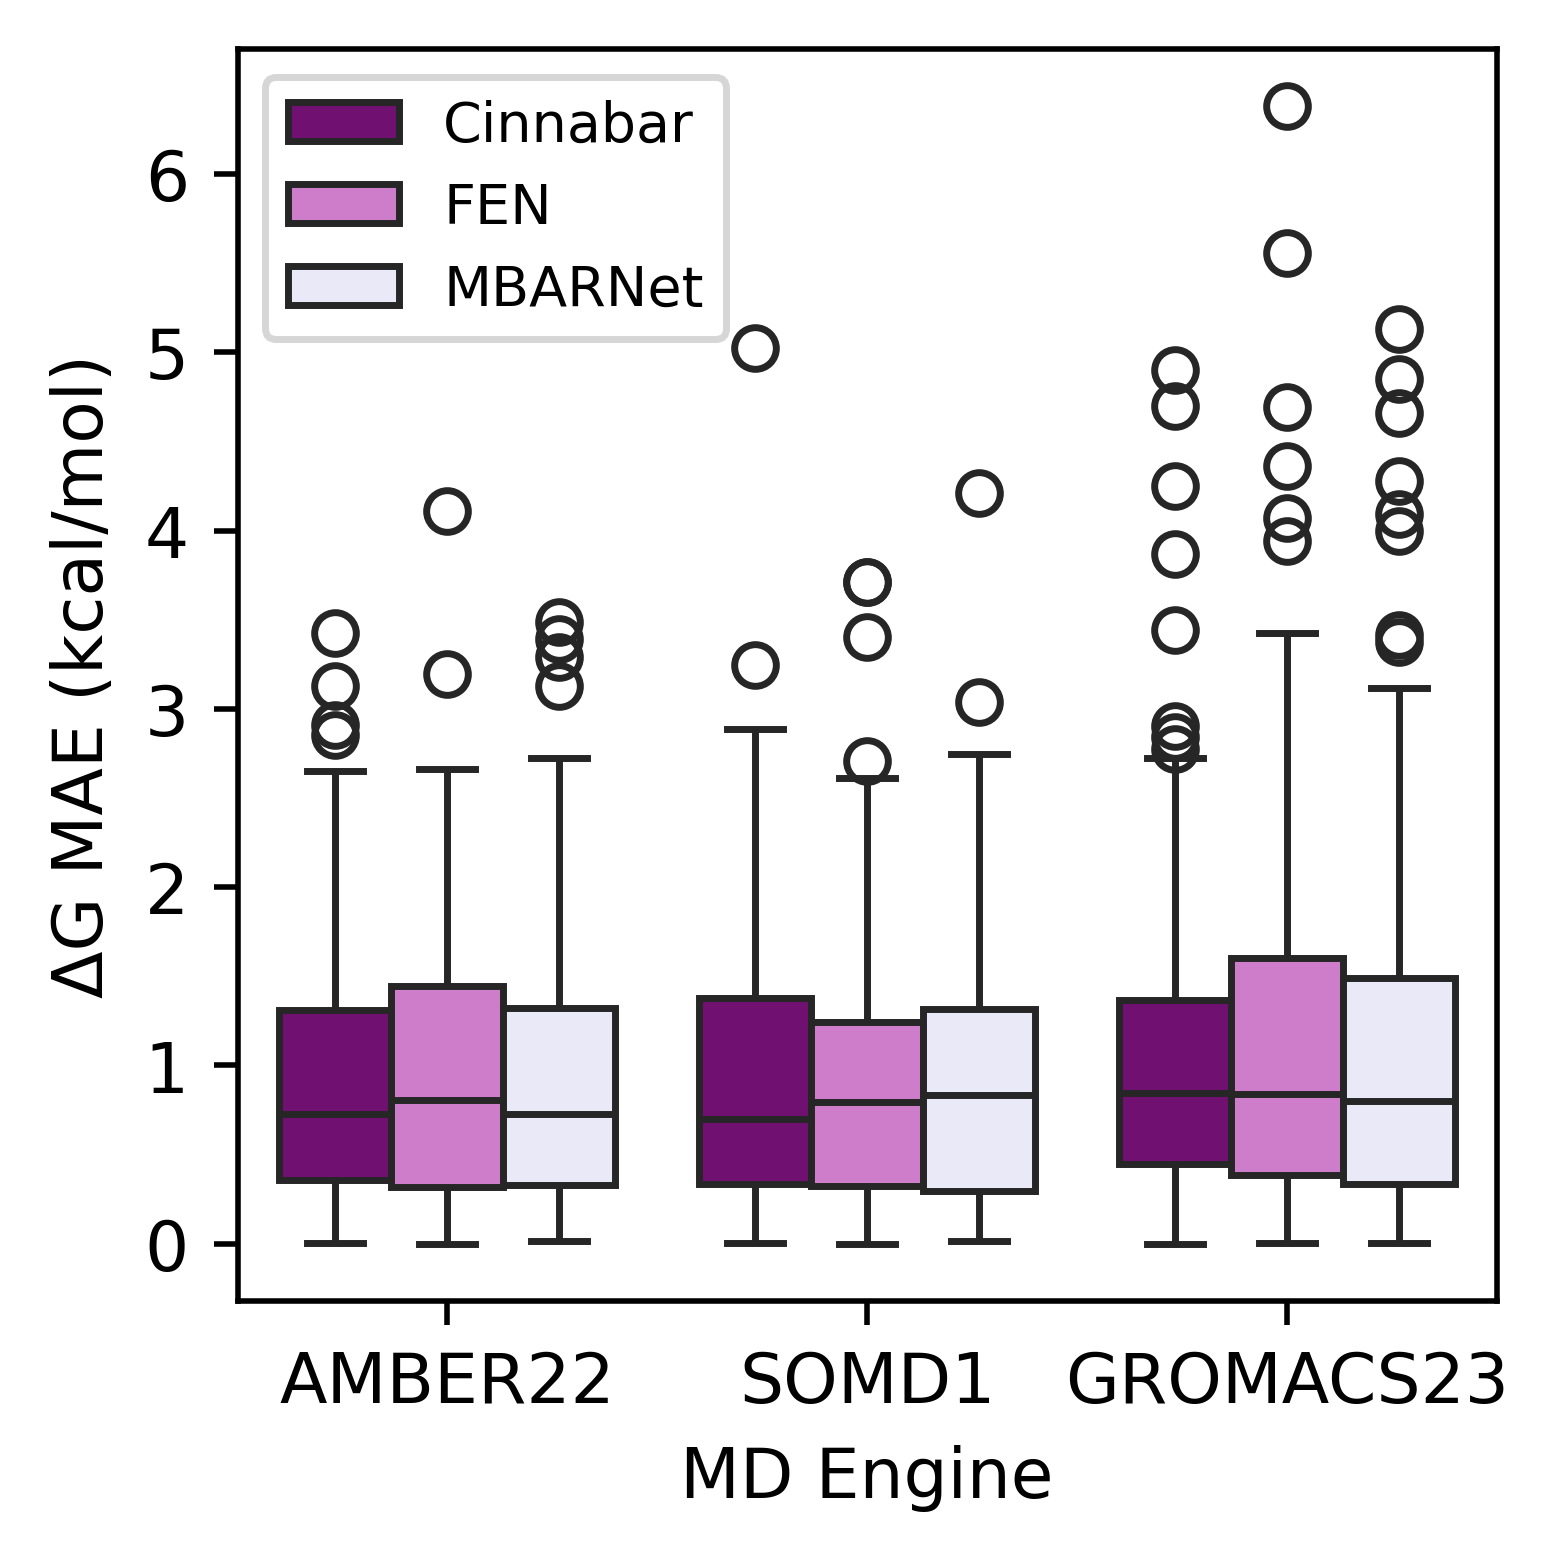

In [102]:
plotting_dict = {
    "method": flatten_comprehension(net_ana_method_dict["method"]),
    "MD engine": flatten_comprehension(net_ana_method_dict["engine"]),
    "MAE dG (kcal/mol)": flatten_comprehension(net_ana_method_dict["value"]),
    "Protein": flatten_comprehension(net_ana_method_dict["protein"]),
}

fig, ax = plt.subplots(figsize=(3.25, 3.25), dpi=500)
df = pd.DataFrame(plotting_dict)
sns.boxplot(
    df,
    x="MD engine",
    y="MAE dG (kcal/mol)",
    hue="method",
    palette=["purple", "orchid", "lavender"],
    ax=ax,
)
# modify individual font size of elements
plt.legend(fontsize=8)
plt.xlabel("MD Engine", fontsize=10)
plt.ylabel("ΔG MAE (kcal/mol)", fontsize=10)
plt.tick_params(axis="both", which="major", labelsize=10)
# ax.set_ylim(top=12)